In [54]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helium

plotdir = '../../cvxportfolio/portfolio/plots/'
datadir='../../cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

start_t="2012-01-01"
end_t="2016-12-31"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
subset_tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE', 'IBM', 'BAC', 'C', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [57]:
indices = returns.columns.intersection(sigmas.columns).intersection(volumes.columns)

In [58]:
cash_ticker = "_CASH"

In [59]:
w_b = pd.Series(index=indices, data=1)
w_b[cash_ticker] = 0.
w_b/=sum(w_b)

In [60]:
returns = returns.rename(columns={"USDOLLAR":cash_ticker})

In [61]:
borrow_costs = returns.copy()
borrow_costs[:] = 1E-4
borrow_costs[cash_ticker] = 0.

dividends = returns.copy()
dividends[:] = 0.

In [62]:
sigmas[cash_ticker] = 0.

In [63]:
volumes = volumes.iloc[1:]

In [64]:
volumes[cash_ticker] = np.finfo(np.float).max

In [65]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=0.0005/2,
                                   nonlin_coef = 1.,
                                   sigmas = sigmas, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [66]:
hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=dividends, dividends=dividends)

In [67]:
simulator = helium.MarketSimulator(returns, volumes, costs=[tcost_model, hcost_model], cash_ticker='_CASH')

In [68]:
(returns.shape, volumes.shape, borrow_costs.shape, dividends.shape)

((2517, 7), (2517, 7), (2517, 7), (2517, 7))

In [69]:
policies = [helium.PeriodicRebalance(target=w_b, period=p) for p in ['day', 'week', 'month', 'quarter', 'year']]
policies.append(helium.Hold())

In [70]:
res = pd.DataFrame(index=['Daily','Weekly','Monthly','Quarterly','Annually','Hold'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multi(fund_val*w_b, start_date=start_t, end_date=end_t, policies=policies, parallel=False)

INFO:root:Backtest started, from 2012-01-03 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at date: 2012-01-03 00:00:00
INFO:root:Propagating portfolio at time 2012-01-03 00:00:00
INFO:root:Getting trades at date: 2012-01-04 00:00:00
INFO:root:Propagating portfolio at time 2012-01-04 00:00:00
INFO:root:Getting trades at date: 2012-01-05 00:00:00
INFO:root:Propagating portfolio at time 2012-01-05 00:00:00
INFO:root:Getting trades at date: 2012-01-06 00:00:00
INFO:root:Propagating portfolio at time 2012-01-06 00:00:00
INFO:root:Getting trades at date: 2012-01-09 00:00:00
INFO:root:Propagating portfolio at time 2012-01-09 00:00:00
INFO:root:Getting trades at date: 2012-01-10 00:00:00
INFO:root:Propagating portfolio at time 2012-01-10 00:00:00
INFO:root:Getting trades at date: 2012-01-11 00:00:00
INFO:root:Propagating portfolio at time 2012-01-11 00:00:00
INFO:root:Getting trades at date: 2012-01-12 00:00:00
INFO:root:Propagating portfolio at time 2012-01-12 00:00:00
INFO:root:Ge

INFO:root:Propagating portfolio at time 2012-04-16 00:00:00
INFO:root:Getting trades at date: 2012-04-17 00:00:00
INFO:root:Propagating portfolio at time 2012-04-17 00:00:00
INFO:root:Getting trades at date: 2012-04-18 00:00:00
INFO:root:Propagating portfolio at time 2012-04-18 00:00:00
INFO:root:Getting trades at date: 2012-04-19 00:00:00
INFO:root:Propagating portfolio at time 2012-04-19 00:00:00
INFO:root:Getting trades at date: 2012-04-20 00:00:00
INFO:root:Propagating portfolio at time 2012-04-20 00:00:00
INFO:root:Getting trades at date: 2012-04-23 00:00:00
INFO:root:Propagating portfolio at time 2012-04-23 00:00:00
INFO:root:Getting trades at date: 2012-04-24 00:00:00
INFO:root:Propagating portfolio at time 2012-04-24 00:00:00
INFO:root:Getting trades at date: 2012-04-25 00:00:00
INFO:root:Propagating portfolio at time 2012-04-25 00:00:00
INFO:root:Getting trades at date: 2012-04-26 00:00:00
INFO:root:Propagating portfolio at time 2012-04-26 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-07-27 00:00:00
INFO:root:Getting trades at date: 2012-07-30 00:00:00
INFO:root:Propagating portfolio at time 2012-07-30 00:00:00
INFO:root:Getting trades at date: 2012-07-31 00:00:00
INFO:root:Propagating portfolio at time 2012-07-31 00:00:00
INFO:root:Getting trades at date: 2012-08-01 00:00:00
INFO:root:Propagating portfolio at time 2012-08-01 00:00:00
INFO:root:Getting trades at date: 2012-08-02 00:00:00
INFO:root:Propagating portfolio at time 2012-08-02 00:00:00
INFO:root:Getting trades at date: 2012-08-03 00:00:00
INFO:root:Propagating portfolio at time 2012-08-03 00:00:00
INFO:root:Getting trades at date: 2012-08-06 00:00:00
INFO:root:Propagating portfolio at time 2012-08-06 00:00:00
INFO:root:Getting trades at date: 2012-08-07 00:00:00
INFO:root:Propagating portfolio at time 2012-08-07 00:00:00
INFO:root:Getting trades at date: 2012-08-08 00:00:00
INFO:root:Propagating portfolio at time 2012-08-08 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-11-09 00:00:00
INFO:root:Getting trades at date: 2012-11-12 00:00:00
INFO:root:Propagating portfolio at time 2012-11-12 00:00:00
INFO:root:Getting trades at date: 2012-11-13 00:00:00
INFO:root:Propagating portfolio at time 2012-11-13 00:00:00
INFO:root:Getting trades at date: 2012-11-14 00:00:00
INFO:root:Propagating portfolio at time 2012-11-14 00:00:00
INFO:root:Getting trades at date: 2012-11-15 00:00:00
INFO:root:Propagating portfolio at time 2012-11-15 00:00:00
INFO:root:Getting trades at date: 2012-11-16 00:00:00
INFO:root:Propagating portfolio at time 2012-11-16 00:00:00
INFO:root:Getting trades at date: 2012-11-19 00:00:00
INFO:root:Propagating portfolio at time 2012-11-19 00:00:00
INFO:root:Getting trades at date: 2012-11-20 00:00:00
INFO:root:Propagating portfolio at time 2012-11-20 00:00:00
INFO:root:Getting trades at date: 2012-11-21 00:00:00
INFO:root:Propagating portfolio at time 2012-11-21 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-02-26 00:00:00
INFO:root:Getting trades at date: 2013-02-27 00:00:00
INFO:root:Propagating portfolio at time 2013-02-27 00:00:00
INFO:root:Getting trades at date: 2013-02-28 00:00:00
INFO:root:Propagating portfolio at time 2013-02-28 00:00:00
INFO:root:Getting trades at date: 2013-03-01 00:00:00
INFO:root:Propagating portfolio at time 2013-03-01 00:00:00
INFO:root:Getting trades at date: 2013-03-04 00:00:00
INFO:root:Propagating portfolio at time 2013-03-04 00:00:00
INFO:root:Getting trades at date: 2013-03-05 00:00:00
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00
INFO:root:Getting trades at date: 2013-03-06 00:00:00
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-06-10 00:00:00
INFO:root:Getting trades at date: 2013-06-11 00:00:00
INFO:root:Propagating portfolio at time 2013-06-11 00:00:00
INFO:root:Getting trades at date: 2013-06-12 00:00:00
INFO:root:Propagating portfolio at time 2013-06-12 00:00:00
INFO:root:Getting trades at date: 2013-06-13 00:00:00
INFO:root:Propagating portfolio at time 2013-06-13 00:00:00
INFO:root:Getting trades at date: 2013-06-14 00:00:00
INFO:root:Propagating portfolio at time 2013-06-14 00:00:00
INFO:root:Getting trades at date: 2013-06-17 00:00:00
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00
INFO:root:Getting trades at date: 2013-06-18 00:00:00
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-09-20 00:00:00
INFO:root:Getting trades at date: 2013-09-23 00:00:00
INFO:root:Propagating portfolio at time 2013-09-23 00:00:00
INFO:root:Getting trades at date: 2013-09-24 00:00:00
INFO:root:Propagating portfolio at time 2013-09-24 00:00:00
INFO:root:Getting trades at date: 2013-09-25 00:00:00
INFO:root:Propagating portfolio at time 2013-09-25 00:00:00
INFO:root:Getting trades at date: 2013-09-26 00:00:00
INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00
INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2014-01-03 00:00:00
INFO:root:Propagating portfolio at time 2014-01-03 00:00:00
INFO:root:Getting trades at date: 2014-01-06 00:00:00
INFO:root:Propagating portfolio at time 2014-01-06 00:00:00
INFO:root:Getting trades at date: 2014-01-07 00:00:00
INFO:root:Propagating portfolio at time 2014-01-07 00:00:00
INFO:root:Getting trades at date: 2014-01-08 00:00:00
INFO:root:Propagating portfolio at time 2014-01-08 00:00:00
INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00
INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-04-17 00:00:00
INFO:root:Propagating portfolio at time 2014-04-17 00:00:00
INFO:root:Getting trades at date: 2014-04-21 00:00:00
INFO:root:Propagating portfolio at time 2014-04-21 00:00:00
INFO:root:Getting trades at date: 2014-04-22 00:00:00
INFO:root:Propagating portfolio at time 2014-04-22 00:00:00
INFO:root:Getting trades at date: 2014-04-23 00:00:00
INFO:root:Propagating portfolio at time 2014-04-23 00:00:00
INFO:root:Getting trades at date: 2014-04-24 00:00:00
INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-07-31 00:00:00
INFO:root:Propagating portfolio at time 2014-07-31 00:00:00
INFO:root:Getting trades at date: 2014-08-01 00:00:00
INFO:root:Propagating portfolio at time 2014-08-01 00:00:00
INFO:root:Getting trades at date: 2014-08-04 00:00:00
INFO:root:Propagating portfolio at time 2014-08-04 00:00:00
INFO:root:Getting trades at date: 2014-08-05 00:00:00
INFO:root:Propagating portfolio at time 2014-08-05 00:00:00
INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00
INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-11-11 00:00:00
INFO:root:Propagating portfolio at time 2014-11-11 00:00:00
INFO:root:Getting trades at date: 2014-11-12 00:00:00
INFO:root:Propagating portfolio at time 2014-11-12 00:00:00
INFO:root:Getting trades at date: 2014-11-13 00:00:00
INFO:root:Propagating portfolio at time 2014-11-13 00:00:00
INFO:root:Getting trades at date: 2014-11-14 00:00:00
INFO:root:Propagating portfolio at time 2014-11-14 00:00:00
INFO:root:Getting trades at date: 2014-11-17 00:00:00
INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-02-26 00:00:00
INFO:root:Propagating portfolio at time 2015-02-26 00:00:00
INFO:root:Getting trades at date: 2015-02-27 00:00:00
INFO:root:Propagating portfolio at time 2015-02-27 00:00:00
INFO:root:Getting trades at date: 2015-03-02 00:00:00
INFO:root:Propagating portfolio at time 2015-03-02 00:00:00
INFO:root:Getting trades at date: 2015-03-03 00:00:00
INFO:root:Propagating portfolio at time 2015-03-03 00:00:00
INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00
INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-10 00:00:00
INFO:root:Propagating portfolio at time 2015-06-10 00:00:00
INFO:root:Getting trades at date: 2015-06-11 00:00:00
INFO:root:Propagating portfolio at time 2015-06-11 00:00:00
INFO:root:Getting trades at date: 2015-06-12 00:00:00
INFO:root:Propagating portfolio at time 2015-06-12 00:00:00
INFO:root:Getting trades at date: 2015-06-15 00:00:00
INFO:root:Propagating portfolio at time 2015-06-15 00:00:00
INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00
INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-09-22 00:00:00
INFO:root:Propagating portfolio at time 2015-09-22 00:00:00
INFO:root:Getting trades at date: 2015-09-23 00:00:00
INFO:root:Propagating portfolio at time 2015-09-23 00:00:00
INFO:root:Getting trades at date: 2015-09-24 00:00:00
INFO:root:Propagating portfolio at time 2015-09-24 00:00:00
INFO:root:Getting trades at date: 2015-09-25 00:00:00
INFO:root:Propagating portfolio at time 2015-09-25 00:00:00
INFO:root:Getting trades at date: 2015-09-28 00:00:00
INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00
INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-05 00:00:00
INFO:root:Propagating portfolio at time 2016-01-05 00:00:00
INFO:root:Getting trades at date: 2016-01-06 00:00:00
INFO:root:Propagating portfolio at time 2016-01-06 00:00:00
INFO:root:Getting trades at date: 2016-01-07 00:00:00
INFO:root:Propagating portfolio at time 2016-01-07 00:00:00
INFO:root:Getting trades at date: 2016-01-08 00:00:00
INFO:root:Propagating portfolio at time 2016-01-08 00:00:00
INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00
INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00
INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-04-19 00:00:00
INFO:root:Propagating portfolio at time 2016-04-19 00:00:00
INFO:root:Getting trades at date: 2016-04-20 00:00:00
INFO:root:Propagating portfolio at time 2016-04-20 00:00:00
INFO:root:Getting trades at date: 2016-04-21 00:00:00
INFO:root:Propagating portfolio at time 2016-04-21 00:00:00
INFO:root:Getting trades at date: 2016-04-22 00:00:00
INFO:root:Propagating portfolio at time 2016-04-22 00:00:00
INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00
INFO:root:Getting trades at date: 2016-04-28 00:00:00
INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-01 00:00:00
INFO:root:Propagating portfolio at time 2016-08-01 00:00:00
INFO:root:Getting trades at date: 2016-08-02 00:00:00
INFO:root:Propagating portfolio at time 2016-08-02 00:00:00
INFO:root:Getting trades at date: 2016-08-03 00:00:00
INFO:root:Propagating portfolio at time 2016-08-03 00:00:00
INFO:root:Getting trades at date: 2016-08-04 00:00:00
INFO:root:Propagating portfolio at time 2016-08-04 00:00:00
INFO:root:Getting trades at date: 2016-08-05 00:00:00
INFO:root:Propagating portfolio at time 2016-08-05 00:00:00
INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-10 00:00:00
INFO:root:Propagating portfolio at time 2016-11-10 00:00:00
INFO:root:Getting trades at date: 2016-11-11 00:00:00
INFO:root:Propagating portfolio at time 2016-11-11 00:00:00
INFO:root:Getting trades at date: 2016-11-14 00:00:00
INFO:root:Propagating portfolio at time 2016-11-14 00:00:00
INFO:root:Getting trades at date: 2016-11-15 00:00:00
INFO:root:Propagating portfolio at time 2016-11-15 00:00:00
INFO:root:Getting trades at date: 2016-11-16 00:00:00
INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-02-24 00:00:00
INFO:root:Getting trades at date: 2012-02-27 00:00:00
INFO:root:Propagating portfolio at time 2012-02-27 00:00:00
INFO:root:Getting trades at date: 2012-02-28 00:00:00
INFO:root:Propagating portfolio at time 2012-02-28 00:00:00
INFO:root:Getting trades at date: 2012-02-29 00:00:00
INFO:root:Propagating portfolio at time 2012-02-29 00:00:00
INFO:root:Getting trades at date: 2012-03-01 00:00:00
INFO:root:Propagating portfolio at time 2012-03-01 00:00:00
INFO:root:Getting trades at date: 2012-03-02 00:00:00
INFO:root:Propagating portfolio at time 2012-03-02 00:00:00
INFO:root:Getting trades at date: 2012-03-05 00:00:00
INFO:root:Propagating portfolio at time 2012-03-05 00:00:00
INFO:root:Getting trades at date: 2012-03-06 00:00:00
INFO:root:Propagating portfolio at time 2012-03-06 00:00:00
INFO:root:Getting trades at date: 2012-03-07 00:00:00
INFO:root:Propagating portfolio at time 2012-03-07 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-07 00:00:00
INFO:root:Getting trades at date: 2012-06-08 00:00:00
INFO:root:Propagating portfolio at time 2012-06-08 00:00:00
INFO:root:Getting trades at date: 2012-06-11 00:00:00
INFO:root:Propagating portfolio at time 2012-06-11 00:00:00
INFO:root:Getting trades at date: 2012-06-12 00:00:00
INFO:root:Propagating portfolio at time 2012-06-12 00:00:00
INFO:root:Getting trades at date: 2012-06-13 00:00:00
INFO:root:Propagating portfolio at time 2012-06-13 00:00:00
INFO:root:Getting trades at date: 2012-06-14 00:00:00
INFO:root:Propagating portfolio at time 2012-06-14 00:00:00
INFO:root:Getting trades at date: 2012-06-15 00:00:00
INFO:root:Propagating portfolio at time 2012-06-15 00:00:00
INFO:root:Getting trades at date: 2012-06-18 00:00:00
INFO:root:Propagating portfolio at time 2012-06-18 00:00:00
INFO:root:Getting trades at date: 2012-06-19 00:00:00
INFO:root:Propagating portfolio at time 2012-06-19 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-09-19 00:00:00
INFO:root:Getting trades at date: 2012-09-20 00:00:00
INFO:root:Propagating portfolio at time 2012-09-20 00:00:00
INFO:root:Getting trades at date: 2012-09-21 00:00:00
INFO:root:Propagating portfolio at time 2012-09-21 00:00:00
INFO:root:Getting trades at date: 2012-09-24 00:00:00
INFO:root:Propagating portfolio at time 2012-09-24 00:00:00
INFO:root:Getting trades at date: 2012-09-25 00:00:00
INFO:root:Propagating portfolio at time 2012-09-25 00:00:00
INFO:root:Getting trades at date: 2012-09-26 00:00:00
INFO:root:Propagating portfolio at time 2012-09-26 00:00:00
INFO:root:Getting trades at date: 2012-09-27 00:00:00
INFO:root:Propagating portfolio at time 2012-09-27 00:00:00
INFO:root:Getting trades at date: 2012-09-28 00:00:00
INFO:root:Propagating portfolio at time 2012-09-28 00:00:00
INFO:root:Getting trades at date: 2012-10-01 00:00:00
INFO:root:Propagating portfolio at time 2012-10-01 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-01-04 00:00:00
INFO:root:Getting trades at date: 2013-01-07 00:00:00
INFO:root:Propagating portfolio at time 2013-01-07 00:00:00
INFO:root:Getting trades at date: 2013-01-08 00:00:00
INFO:root:Propagating portfolio at time 2013-01-08 00:00:00
INFO:root:Getting trades at date: 2013-01-09 00:00:00
INFO:root:Propagating portfolio at time 2013-01-09 00:00:00
INFO:root:Getting trades at date: 2013-01-10 00:00:00
INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00
INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-04-19 00:00:00
INFO:root:Getting trades at date: 2013-04-22 00:00:00
INFO:root:Propagating portfolio at time 2013-04-22 00:00:00
INFO:root:Getting trades at date: 2013-04-23 00:00:00
INFO:root:Propagating portfolio at time 2013-04-23 00:00:00
INFO:root:Getting trades at date: 2013-04-24 00:00:00
INFO:root:Propagating portfolio at time 2013-04-24 00:00:00
INFO:root:Getting trades at date: 2013-04-25 00:00:00
INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00
INFO:root:Getting trades at date: 2013-04-30 00:00:00
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-08-01 00:00:00
INFO:root:Getting trades at date: 2013-08-02 00:00:00
INFO:root:Propagating portfolio at time 2013-08-02 00:00:00
INFO:root:Getting trades at date: 2013-08-05 00:00:00
INFO:root:Propagating portfolio at time 2013-08-05 00:00:00
INFO:root:Getting trades at date: 2013-08-06 00:00:00
INFO:root:Propagating portfolio at time 2013-08-06 00:00:00
INFO:root:Getting trades at date: 2013-08-07 00:00:00
INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-11-12 00:00:00
INFO:root:Getting trades at date: 2013-11-13 00:00:00
INFO:root:Propagating portfolio at time 2013-11-13 00:00:00
INFO:root:Getting trades at date: 2013-11-14 00:00:00
INFO:root:Propagating portfolio at time 2013-11-14 00:00:00
INFO:root:Getting trades at date: 2013-11-15 00:00:00
INFO:root:Propagating portfolio at time 2013-11-15 00:00:00
INFO:root:Getting trades at date: 2013-11-18 00:00:00
INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00
INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00
INFO:root:Getting trades at date: 2013-11-21 00:00:00
INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-02-27 00:00:00
INFO:root:Getting trades at date: 2014-02-28 00:00:00
INFO:root:Propagating portfolio at time 2014-02-28 00:00:00
INFO:root:Getting trades at date: 2014-03-03 00:00:00
INFO:root:Propagating portfolio at time 2014-03-03 00:00:00
INFO:root:Getting trades at date: 2014-03-04 00:00:00
INFO:root:Propagating portfolio at time 2014-03-04 00:00:00
INFO:root:Getting trades at date: 2014-03-05 00:00:00
INFO:root:Propagating portfolio at time 2014-03-05 00:00:00
INFO:root:Getting trades at date: 2014-03-06 00:00:00
INFO:root:Propagating portfolio at time 2014-03-06 00:00:00
INFO:root:Getting trades at date: 2014-03-07 00:00:00
INFO:root:Propagating portfolio at time 2014-03-07 00:00:00
INFO:root:Getting trades at date: 2014-03-10 00:00:00
INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00
INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-06-11 00:00:00
INFO:root:Getting trades at date: 2014-06-12 00:00:00
INFO:root:Propagating portfolio at time 2014-06-12 00:00:00
INFO:root:Getting trades at date: 2014-06-13 00:00:00
INFO:root:Propagating portfolio at time 2014-06-13 00:00:00
INFO:root:Getting trades at date: 2014-06-16 00:00:00
INFO:root:Propagating portfolio at time 2014-06-16 00:00:00
INFO:root:Getting trades at date: 2014-06-17 00:00:00
INFO:root:Propagating portfolio at time 2014-06-17 00:00:00
INFO:root:Getting trades at date: 2014-06-18 00:00:00
INFO:root:Propagating portfolio at time 2014-06-18 00:00:00
INFO:root:Getting trades at date: 2014-06-19 00:00:00
INFO:root:Propagating portfolio at time 2014-06-19 00:00:00
INFO:root:Getting trades at date: 2014-06-20 00:00:00
INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00
INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-09-23 00:00:00
INFO:root:Getting trades at date: 2014-09-24 00:00:00
INFO:root:Propagating portfolio at time 2014-09-24 00:00:00
INFO:root:Getting trades at date: 2014-09-25 00:00:00
INFO:root:Propagating portfolio at time 2014-09-25 00:00:00
INFO:root:Getting trades at date: 2014-09-26 00:00:00
INFO:root:Propagating portfolio at time 2014-09-26 00:00:00
INFO:root:Getting trades at date: 2014-09-29 00:00:00
INFO:root:Propagating portfolio at time 2014-09-29 00:00:00
INFO:root:Getting trades at date: 2014-09-30 00:00:00
INFO:root:Propagating portfolio at time 2014-09-30 00:00:00
INFO:root:Getting trades at date: 2014-10-01 00:00:00
INFO:root:Propagating portfolio at time 2014-10-01 00:00:00
INFO:root:Getting trades at date: 2014-10-02 00:00:00
INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-01-06 00:00:00
INFO:root:Getting trades at date: 2015-01-07 00:00:00
INFO:root:Propagating portfolio at time 2015-01-07 00:00:00
INFO:root:Getting trades at date: 2015-01-08 00:00:00
INFO:root:Propagating portfolio at time 2015-01-08 00:00:00
INFO:root:Getting trades at date: 2015-01-09 00:00:00
INFO:root:Propagating portfolio at time 2015-01-09 00:00:00
INFO:root:Getting trades at date: 2015-01-12 00:00:00
INFO:root:Propagating portfolio at time 2015-01-12 00:00:00
INFO:root:Getting trades at date: 2015-01-13 00:00:00
INFO:root:Propagating portfolio at time 2015-01-13 00:00:00
INFO:root:Getting trades at date: 2015-01-14 00:00:00
INFO:root:Propagating portfolio at time 2015-01-14 00:00:00
INFO:root:Getting trades at date: 2015-01-15 00:00:00
INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-04-21 00:00:00
INFO:root:Getting trades at date: 2015-04-22 00:00:00
INFO:root:Propagating portfolio at time 2015-04-22 00:00:00
INFO:root:Getting trades at date: 2015-04-23 00:00:00
INFO:root:Propagating portfolio at time 2015-04-23 00:00:00
INFO:root:Getting trades at date: 2015-04-24 00:00:00
INFO:root:Propagating portfolio at time 2015-04-24 00:00:00
INFO:root:Getting trades at date: 2015-04-27 00:00:00
INFO:root:Propagating portfolio at time 2015-04-27 00:00:00
INFO:root:Getting trades at date: 2015-04-28 00:00:00
INFO:root:Propagating portfolio at time 2015-04-28 00:00:00
INFO:root:Getting trades at date: 2015-04-29 00:00:00
INFO:root:Propagating portfolio at time 2015-04-29 00:00:00
INFO:root:Getting trades at date: 2015-04-30 00:00:00
INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-08-03 00:00:00
INFO:root:Getting trades at date: 2015-08-04 00:00:00
INFO:root:Propagating portfolio at time 2015-08-04 00:00:00
INFO:root:Getting trades at date: 2015-08-05 00:00:00
INFO:root:Propagating portfolio at time 2015-08-05 00:00:00
INFO:root:Getting trades at date: 2015-08-06 00:00:00
INFO:root:Propagating portfolio at time 2015-08-06 00:00:00
INFO:root:Getting trades at date: 2015-08-07 00:00:00
INFO:root:Propagating portfolio at time 2015-08-07 00:00:00
INFO:root:Getting trades at date: 2015-08-10 00:00:00
INFO:root:Propagating portfolio at time 2015-08-10 00:00:00
INFO:root:Getting trades at date: 2015-08-11 00:00:00
INFO:root:Propagating portfolio at time 2015-08-11 00:00:00
INFO:root:Getting trades at date: 2015-08-12 00:00:00
INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-11-12 00:00:00
INFO:root:Getting trades at date: 2015-11-13 00:00:00
INFO:root:Propagating portfolio at time 2015-11-13 00:00:00
INFO:root:Getting trades at date: 2015-11-16 00:00:00
INFO:root:Propagating portfolio at time 2015-11-16 00:00:00
INFO:root:Getting trades at date: 2015-11-17 00:00:00
INFO:root:Propagating portfolio at time 2015-11-17 00:00:00
INFO:root:Getting trades at date: 2015-11-18 00:00:00
INFO:root:Propagating portfolio at time 2015-11-18 00:00:00
INFO:root:Getting trades at date: 2015-11-19 00:00:00
INFO:root:Propagating portfolio at time 2015-11-19 00:00:00
INFO:root:Getting trades at date: 2015-11-20 00:00:00
INFO:root:Propagating portfolio at time 2015-11-20 00:00:00
INFO:root:Getting trades at date: 2015-11-23 00:00:00
INFO:root:Propagating portfolio at time 2015-11-23 00:00:00
INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2016-02-29 00:00:00
INFO:root:Propagating portfolio at time 2016-02-29 00:00:00
INFO:root:Getting trades at date: 2016-03-01 00:00:00
INFO:root:Propagating portfolio at time 2016-03-01 00:00:00
INFO:root:Getting trades at date: 2016-03-02 00:00:00
INFO:root:Propagating portfolio at time 2016-03-02 00:00:00
INFO:root:Getting trades at date: 2016-03-03 00:00:00
INFO:root:Propagating portfolio at time 2016-03-03 00:00:00
INFO:root:Getting trades at date: 2016-03-04 00:00:00
INFO:root:Propagating portfolio at time 2016-03-04 00:00:00
INFO:root:Getting trades at date: 2016-03-07 00:00:00
INFO:root:Propagating portfolio at time 2016-03-07 00:00:00
INFO:root:Getting trades at date: 2016-03-08 00:00:00
INFO:root:Propagating portfolio at time 2016-03-08 00:00:00
INFO:root:Getting trades at date: 2016-03-09 00:00:00
INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-06-10 00:00:00
INFO:root:Propagating portfolio at time 2016-06-10 00:00:00
INFO:root:Getting trades at date: 2016-06-13 00:00:00
INFO:root:Propagating portfolio at time 2016-06-13 00:00:00
INFO:root:Getting trades at date: 2016-06-14 00:00:00
INFO:root:Propagating portfolio at time 2016-06-14 00:00:00
INFO:root:Getting trades at date: 2016-06-15 00:00:00
INFO:root:Propagating portfolio at time 2016-06-15 00:00:00
INFO:root:Getting trades at date: 2016-06-16 00:00:00
INFO:root:Propagating portfolio at time 2016-06-16 00:00:00
INFO:root:Getting trades at date: 2016-06-17 00:00:00
INFO:root:Propagating portfolio at time 2016-06-17 00:00:00
INFO:root:Getting trades at date: 2016-06-20 00:00:00
INFO:root:Propagating portfolio at time 2016-06-20 00:00:00
INFO:root:Getting trades at date: 2016-06-21 00:00:00
INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-09-22 00:00:00
INFO:root:Propagating portfolio at time 2016-09-22 00:00:00
INFO:root:Getting trades at date: 2016-09-23 00:00:00
INFO:root:Propagating portfolio at time 2016-09-23 00:00:00
INFO:root:Getting trades at date: 2016-09-26 00:00:00
INFO:root:Propagating portfolio at time 2016-09-26 00:00:00
INFO:root:Getting trades at date: 2016-09-27 00:00:00
INFO:root:Propagating portfolio at time 2016-09-27 00:00:00
INFO:root:Getting trades at date: 2016-09-28 00:00:00
INFO:root:Propagating portfolio at time 2016-09-28 00:00:00
INFO:root:Getting trades at date: 2016-09-29 00:00:00
INFO:root:Propagating portfolio at time 2016-09-29 00:00:00
INFO:root:Getting trades at date: 2016-09-30 00:00:00
INFO:root:Propagating portfolio at time 2016-09-30 00:00:00
INFO:root:Getting trades at date: 2016-10-03 00:00:00
INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-01-04 00:00:00
INFO:root:Getting trades at date: 2012-01-05 00:00:00
INFO:root:Propagating portfolio at time 2012-01-05 00:00:00
INFO:root:Getting trades at date: 2012-01-06 00:00:00
INFO:root:Propagating portfolio at time 2012-01-06 00:00:00
INFO:root:Getting trades at date: 2012-01-09 00:00:00
INFO:root:Propagating portfolio at time 2012-01-09 00:00:00
INFO:root:Getting trades at date: 2012-01-10 00:00:00
INFO:root:Propagating portfolio at time 2012-01-10 00:00:00
INFO:root:Getting trades at date: 2012-01-11 00:00:00
INFO:root:Propagating portfolio at time 2012-01-11 00:00:00
INFO:root:Getting trades at date: 2012-01-12 00:00:00
INFO:root:Propagating portfolio at time 2012-01-12 00:00:00
INFO:root:Getting trades at date: 2012-01-13 00:00:00
INFO:root:Propagating portfolio at time 2012-01-13 00:00:00
INFO:root:Getting trades at date: 2012-01-17 00:00:00
INFO:root:Propagating portfolio at time 2012-01-17 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-04-18 00:00:00
INFO:root:Getting trades at date: 2012-04-19 00:00:00
INFO:root:Propagating portfolio at time 2012-04-19 00:00:00
INFO:root:Getting trades at date: 2012-04-20 00:00:00
INFO:root:Propagating portfolio at time 2012-04-20 00:00:00
INFO:root:Getting trades at date: 2012-04-23 00:00:00
INFO:root:Propagating portfolio at time 2012-04-23 00:00:00
INFO:root:Getting trades at date: 2012-04-24 00:00:00
INFO:root:Propagating portfolio at time 2012-04-24 00:00:00
INFO:root:Getting trades at date: 2012-04-25 00:00:00
INFO:root:Propagating portfolio at time 2012-04-25 00:00:00
INFO:root:Getting trades at date: 2012-04-26 00:00:00
INFO:root:Propagating portfolio at time 2012-04-26 00:00:00
INFO:root:Getting trades at date: 2012-04-27 00:00:00
INFO:root:Propagating portfolio at time 2012-04-27 00:00:00
INFO:root:Getting trades at date: 2012-04-30 00:00:00
INFO:root:Propagating portfolio at time 2012-04-30 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-07-31 00:00:00
INFO:root:Getting trades at date: 2012-08-01 00:00:00
INFO:root:Propagating portfolio at time 2012-08-01 00:00:00
INFO:root:Getting trades at date: 2012-08-02 00:00:00
INFO:root:Propagating portfolio at time 2012-08-02 00:00:00
INFO:root:Getting trades at date: 2012-08-03 00:00:00
INFO:root:Propagating portfolio at time 2012-08-03 00:00:00
INFO:root:Getting trades at date: 2012-08-06 00:00:00
INFO:root:Propagating portfolio at time 2012-08-06 00:00:00
INFO:root:Getting trades at date: 2012-08-07 00:00:00
INFO:root:Propagating portfolio at time 2012-08-07 00:00:00
INFO:root:Getting trades at date: 2012-08-08 00:00:00
INFO:root:Propagating portfolio at time 2012-08-08 00:00:00
INFO:root:Getting trades at date: 2012-08-09 00:00:00
INFO:root:Propagating portfolio at time 2012-08-09 00:00:00
INFO:root:Getting trades at date: 2012-08-10 00:00:00
INFO:root:Propagating portfolio at time 2012-08-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-11-13 00:00:00
INFO:root:Getting trades at date: 2012-11-14 00:00:00
INFO:root:Propagating portfolio at time 2012-11-14 00:00:00
INFO:root:Getting trades at date: 2012-11-15 00:00:00
INFO:root:Propagating portfolio at time 2012-11-15 00:00:00
INFO:root:Getting trades at date: 2012-11-16 00:00:00
INFO:root:Propagating portfolio at time 2012-11-16 00:00:00
INFO:root:Getting trades at date: 2012-11-19 00:00:00
INFO:root:Propagating portfolio at time 2012-11-19 00:00:00
INFO:root:Getting trades at date: 2012-11-20 00:00:00
INFO:root:Propagating portfolio at time 2012-11-20 00:00:00
INFO:root:Getting trades at date: 2012-11-21 00:00:00
INFO:root:Propagating portfolio at time 2012-11-21 00:00:00
INFO:root:Getting trades at date: 2012-11-23 00:00:00
INFO:root:Propagating portfolio at time 2012-11-23 00:00:00
INFO:root:Getting trades at date: 2012-11-26 00:00:00
INFO:root:Propagating portfolio at time 2012-11-26 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-02-28 00:00:00
INFO:root:Getting trades at date: 2013-03-01 00:00:00
INFO:root:Propagating portfolio at time 2013-03-01 00:00:00
INFO:root:Getting trades at date: 2013-03-04 00:00:00
INFO:root:Propagating portfolio at time 2013-03-04 00:00:00
INFO:root:Getting trades at date: 2013-03-05 00:00:00
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00
INFO:root:Getting trades at date: 2013-03-06 00:00:00
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-06-12 00:00:00
INFO:root:Getting trades at date: 2013-06-13 00:00:00
INFO:root:Propagating portfolio at time 2013-06-13 00:00:00
INFO:root:Getting trades at date: 2013-06-14 00:00:00
INFO:root:Propagating portfolio at time 2013-06-14 00:00:00
INFO:root:Getting trades at date: 2013-06-17 00:00:00
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00
INFO:root:Getting trades at date: 2013-06-18 00:00:00
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00
INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-09-24 00:00:00
INFO:root:Getting trades at date: 2013-09-25 00:00:00
INFO:root:Propagating portfolio at time 2013-09-25 00:00:00
INFO:root:Getting trades at date: 2013-09-26 00:00:00
INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00
INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-01-07 00:00:00
INFO:root:Getting trades at date: 2014-01-08 00:00:00
INFO:root:Propagating portfolio at time 2014-01-08 00:00:00
INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00
INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at time 2014-01-15 00:00:00
INFO:root:Getting trades at date: 2014-01-16 00:00:00
INFO:root:Propagating portfolio at time 2014-01-16 00:00:00
INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-04-22 00:00:00
INFO:root:Getting trades at date: 2014-04-23 00:00:00
INFO:root:Propagating portfolio at time 2014-04-23 00:00:00
INFO:root:Getting trades at date: 2014-04-24 00:00:00
INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at time 2014-04-30 00:00:00
INFO:root:Getting trades at date: 2014-05-01 00:00:00
INFO:root:Propagating portfolio at time 2014-05-01 00:00:00
INFO:root:Getting trades at date: 2014-05-02 00:00:00
INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-08-04 00:00:00
INFO:root:Getting trades at date: 2014-08-05 00:00:00
INFO:root:Propagating portfolio at time 2014-08-05 00:00:00
INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00
INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at time 2014-08-12 00:00:00
INFO:root:Getting trades at date: 2014-08-13 00:00:00
INFO:root:Propagating portfolio at time 2014-08-13 00:00:00
INFO:root:Getting trades at date: 2014-08-14 00:00:00
INFO:root:Propagating portfolio at time 2014-08-14 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-11-13 00:00:00
INFO:root:Getting trades at date: 2014-11-14 00:00:00
INFO:root:Propagating portfolio at time 2014-11-14 00:00:00
INFO:root:Getting trades at date: 2014-11-17 00:00:00
INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at time 2014-11-21 00:00:00
INFO:root:Getting trades at date: 2014-11-24 00:00:00
INFO:root:Propagating portfolio at time 2014-11-24 00:00:00
INFO:root:Getting trades at date: 2014-11-25 00:00:00
INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2015-03-02 00:00:00
INFO:root:Propagating portfolio at time 2015-03-02 00:00:00
INFO:root:Getting trades at date: 2015-03-03 00:00:00
INFO:root:Propagating portfolio at time 2015-03-03 00:00:00
INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00
INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at time 2015-03-10 00:00:00
INFO:root:Getting trades at date: 2015-03-11 00:00:00
INFO:root:Propagating portfolio at time 2015-03-11 00:00:00
INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-12 00:00:00
INFO:root:Propagating portfolio at time 2015-06-12 00:00:00
INFO:root:Getting trades at date: 2015-06-15 00:00:00
INFO:root:Propagating portfolio at time 2015-06-15 00:00:00
INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00
INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at time 2015-06-22 00:00:00
INFO:root:Getting trades at date: 2015-06-23 00:00:00
INFO:root:Propagating portfolio at time 2015-06-23 00:00:00
INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-09-24 00:00:00
INFO:root:Propagating portfolio at time 2015-09-24 00:00:00
INFO:root:Getting trades at date: 2015-09-25 00:00:00
INFO:root:Propagating portfolio at time 2015-09-25 00:00:00
INFO:root:Getting trades at date: 2015-09-28 00:00:00
INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00
INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at time 2015-10-02 00:00:00
INFO:root:Getting trades at date: 2015-10-05 00:00:00
INFO:root:Propagating portfolio at time 2015-10-05 00:00:00
INFO:root:Getting trades at date: 2015-10-06 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-07 00:00:00
INFO:root:Propagating portfolio at time 2016-01-07 00:00:00
INFO:root:Getting trades at date: 2016-01-08 00:00:00
INFO:root:Propagating portfolio at time 2016-01-08 00:00:00
INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00
INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00
INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at time 2016-01-15 00:00:00
INFO:root:Getting trades at date: 2016-01-19 00:00:00
INFO:root:Propagating portfolio at time 2016-01-19 00:00:00
INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-04-21 00:00:00
INFO:root:Propagating portfolio at time 2016-04-21 00:00:00
INFO:root:Getting trades at date: 2016-04-22 00:00:00
INFO:root:Propagating portfolio at time 2016-04-22 00:00:00
INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00
INFO:root:Getting trades at date: 2016-04-28 00:00:00
INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at time 2016-04-29 00:00:00
INFO:root:Getting trades at date: 2016-05-02 00:00:00
INFO:root:Propagating portfolio at time 2016-05-02 00:00:00
INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-03 00:00:00
INFO:root:Propagating portfolio at time 2016-08-03 00:00:00
INFO:root:Getting trades at date: 2016-08-04 00:00:00
INFO:root:Propagating portfolio at time 2016-08-04 00:00:00
INFO:root:Getting trades at date: 2016-08-05 00:00:00
INFO:root:Propagating portfolio at time 2016-08-05 00:00:00
INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at time 2016-08-11 00:00:00
INFO:root:Getting trades at date: 2016-08-12 00:00:00
INFO:root:Propagating portfolio at time 2016-08-12 00:00:00
INFO:root:Getting trades at date: 2016-08-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-14 00:00:00
INFO:root:Propagating portfolio at time 2016-11-14 00:00:00
INFO:root:Getting trades at date: 2016-11-15 00:00:00
INFO:root:Propagating portfolio at time 2016-11-15 00:00:00
INFO:root:Getting trades at date: 2016-11-16 00:00:00
INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at time 2016-11-22 00:00:00
INFO:root:Getting trades at date: 2016-11-23 00:00:00
INFO:root:Propagating portfolio at time 2016-11-23 00:00:00
INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-02-28 00:00:00
INFO:root:Getting trades at date: 2012-02-29 00:00:00
INFO:root:Propagating portfolio at time 2012-02-29 00:00:00
INFO:root:Getting trades at date: 2012-03-01 00:00:00
INFO:root:Propagating portfolio at time 2012-03-01 00:00:00
INFO:root:Getting trades at date: 2012-03-02 00:00:00
INFO:root:Propagating portfolio at time 2012-03-02 00:00:00
INFO:root:Getting trades at date: 2012-03-05 00:00:00
INFO:root:Propagating portfolio at time 2012-03-05 00:00:00
INFO:root:Getting trades at date: 2012-03-06 00:00:00
INFO:root:Propagating portfolio at time 2012-03-06 00:00:00
INFO:root:Getting trades at date: 2012-03-07 00:00:00
INFO:root:Propagating portfolio at time 2012-03-07 00:00:00
INFO:root:Getting trades at date: 2012-03-08 00:00:00
INFO:root:Propagating portfolio at time 2012-03-08 00:00:00
INFO:root:Getting trades at date: 2012-03-09 00:00:00
INFO:root:Propagating portfolio at time 2012-03-09 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-11 00:00:00
INFO:root:Getting trades at date: 2012-06-12 00:00:00
INFO:root:Propagating portfolio at time 2012-06-12 00:00:00
INFO:root:Getting trades at date: 2012-06-13 00:00:00
INFO:root:Propagating portfolio at time 2012-06-13 00:00:00
INFO:root:Getting trades at date: 2012-06-14 00:00:00
INFO:root:Propagating portfolio at time 2012-06-14 00:00:00
INFO:root:Getting trades at date: 2012-06-15 00:00:00
INFO:root:Propagating portfolio at time 2012-06-15 00:00:00
INFO:root:Getting trades at date: 2012-06-18 00:00:00
INFO:root:Propagating portfolio at time 2012-06-18 00:00:00
INFO:root:Getting trades at date: 2012-06-19 00:00:00
INFO:root:Propagating portfolio at time 2012-06-19 00:00:00
INFO:root:Getting trades at date: 2012-06-20 00:00:00
INFO:root:Propagating portfolio at time 2012-06-20 00:00:00
INFO:root:Getting trades at date: 2012-06-21 00:00:00
INFO:root:Propagating portfolio at time 2012-06-21 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-09-21 00:00:00
INFO:root:Getting trades at date: 2012-09-24 00:00:00
INFO:root:Propagating portfolio at time 2012-09-24 00:00:00
INFO:root:Getting trades at date: 2012-09-25 00:00:00
INFO:root:Propagating portfolio at time 2012-09-25 00:00:00
INFO:root:Getting trades at date: 2012-09-26 00:00:00
INFO:root:Propagating portfolio at time 2012-09-26 00:00:00
INFO:root:Getting trades at date: 2012-09-27 00:00:00
INFO:root:Propagating portfolio at time 2012-09-27 00:00:00
INFO:root:Getting trades at date: 2012-09-28 00:00:00
INFO:root:Propagating portfolio at time 2012-09-28 00:00:00
INFO:root:Getting trades at date: 2012-10-01 00:00:00
INFO:root:Propagating portfolio at time 2012-10-01 00:00:00
INFO:root:Getting trades at date: 2012-10-02 00:00:00
INFO:root:Propagating portfolio at time 2012-10-02 00:00:00
INFO:root:Getting trades at date: 2012-10-03 00:00:00
INFO:root:Propagating portfolio at time 2012-10-03 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-01-08 00:00:00
INFO:root:Getting trades at date: 2013-01-09 00:00:00
INFO:root:Propagating portfolio at time 2013-01-09 00:00:00
INFO:root:Getting trades at date: 2013-01-10 00:00:00
INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00
INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2013-04-23 00:00:00
INFO:root:Propagating portfolio at time 2013-04-23 00:00:00
INFO:root:Getting trades at date: 2013-04-24 00:00:00
INFO:root:Propagating portfolio at time 2013-04-24 00:00:00
INFO:root:Getting trades at date: 2013-04-25 00:00:00
INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00
INFO:root:Getting trades at date: 2013-04-30 00:00:00
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00
INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-08-05 00:00:00
INFO:root:Propagating portfolio at time 2013-08-05 00:00:00
INFO:root:Getting trades at date: 2013-08-06 00:00:00
INFO:root:Propagating portfolio at time 2013-08-06 00:00:00
INFO:root:Getting trades at date: 2013-08-07 00:00:00
INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00
INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-11-14 00:00:00
INFO:root:Propagating portfolio at time 2013-11-14 00:00:00
INFO:root:Getting trades at date: 2013-11-15 00:00:00
INFO:root:Propagating portfolio at time 2013-11-15 00:00:00
INFO:root:Getting trades at date: 2013-11-18 00:00:00
INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00
INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00
INFO:root:Getting trades at date: 2013-11-21 00:00:00
INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-03-03 00:00:00
INFO:root:Propagating portfolio at time 2014-03-03 00:00:00
INFO:root:Getting trades at date: 2014-03-04 00:00:00
INFO:root:Propagating portfolio at time 2014-03-04 00:00:00
INFO:root:Getting trades at date: 2014-03-05 00:00:00
INFO:root:Propagating portfolio at time 2014-03-05 00:00:00
INFO:root:Getting trades at date: 2014-03-06 00:00:00
INFO:root:Propagating portfolio at time 2014-03-06 00:00:00
INFO:root:Getting trades at date: 2014-03-07 00:00:00
INFO:root:Propagating portfolio at time 2014-03-07 00:00:00
INFO:root:Getting trades at date: 2014-03-10 00:00:00
INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00
INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at date: 2014-03-12 00:00:00
INFO:root:Propagating portfolio at time 2014-03-12 00:00:00
INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-06-13 00:00:00
INFO:root:Propagating portfolio at time 2014-06-13 00:00:00
INFO:root:Getting trades at date: 2014-06-16 00:00:00
INFO:root:Propagating portfolio at time 2014-06-16 00:00:00
INFO:root:Getting trades at date: 2014-06-17 00:00:00
INFO:root:Propagating portfolio at time 2014-06-17 00:00:00
INFO:root:Getting trades at date: 2014-06-18 00:00:00
INFO:root:Propagating portfolio at time 2014-06-18 00:00:00
INFO:root:Getting trades at date: 2014-06-19 00:00:00
INFO:root:Propagating portfolio at time 2014-06-19 00:00:00
INFO:root:Getting trades at date: 2014-06-20 00:00:00
INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00
INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at date: 2014-06-24 00:00:00
INFO:root:Propagating portfolio at time 2014-06-24 00:00:00
INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-09-25 00:00:00
INFO:root:Propagating portfolio at time 2014-09-25 00:00:00
INFO:root:Getting trades at date: 2014-09-26 00:00:00
INFO:root:Propagating portfolio at time 2014-09-26 00:00:00
INFO:root:Getting trades at date: 2014-09-29 00:00:00
INFO:root:Propagating portfolio at time 2014-09-29 00:00:00
INFO:root:Getting trades at date: 2014-09-30 00:00:00
INFO:root:Propagating portfolio at time 2014-09-30 00:00:00
INFO:root:Getting trades at date: 2014-10-01 00:00:00
INFO:root:Propagating portfolio at time 2014-10-01 00:00:00
INFO:root:Getting trades at date: 2014-10-02 00:00:00
INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00
INFO:root:Getting trades at date: 2014-10-06 00:00:00
INFO:root:Propagating portfolio at time 2014-10-06 00:00:00
INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-01-08 00:00:00
INFO:root:Propagating portfolio at time 2015-01-08 00:00:00
INFO:root:Getting trades at date: 2015-01-09 00:00:00
INFO:root:Propagating portfolio at time 2015-01-09 00:00:00
INFO:root:Getting trades at date: 2015-01-12 00:00:00
INFO:root:Propagating portfolio at time 2015-01-12 00:00:00
INFO:root:Getting trades at date: 2015-01-13 00:00:00
INFO:root:Propagating portfolio at time 2015-01-13 00:00:00
INFO:root:Getting trades at date: 2015-01-14 00:00:00
INFO:root:Propagating portfolio at time 2015-01-14 00:00:00
INFO:root:Getting trades at date: 2015-01-15 00:00:00
INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at date: 2015-01-20 00:00:00
INFO:root:Propagating portfolio at time 2015-01-20 00:00:00
INFO:root:Getting trades at date: 2015-01-21 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-04-23 00:00:00
INFO:root:Propagating portfolio at time 2015-04-23 00:00:00
INFO:root:Getting trades at date: 2015-04-24 00:00:00
INFO:root:Propagating portfolio at time 2015-04-24 00:00:00
INFO:root:Getting trades at date: 2015-04-27 00:00:00
INFO:root:Propagating portfolio at time 2015-04-27 00:00:00
INFO:root:Getting trades at date: 2015-04-28 00:00:00
INFO:root:Propagating portfolio at time 2015-04-28 00:00:00
INFO:root:Getting trades at date: 2015-04-29 00:00:00
INFO:root:Propagating portfolio at time 2015-04-29 00:00:00
INFO:root:Getting trades at date: 2015-04-30 00:00:00
INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at date: 2015-05-04 00:00:00
INFO:root:Propagating portfolio at time 2015-05-04 00:00:00
INFO:root:Getting trades at date: 2015-05-05 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-08-05 00:00:00
INFO:root:Propagating portfolio at time 2015-08-05 00:00:00
INFO:root:Getting trades at date: 2015-08-06 00:00:00
INFO:root:Propagating portfolio at time 2015-08-06 00:00:00
INFO:root:Getting trades at date: 2015-08-07 00:00:00
INFO:root:Propagating portfolio at time 2015-08-07 00:00:00
INFO:root:Getting trades at date: 2015-08-10 00:00:00
INFO:root:Propagating portfolio at time 2015-08-10 00:00:00
INFO:root:Getting trades at date: 2015-08-11 00:00:00
INFO:root:Propagating portfolio at time 2015-08-11 00:00:00
INFO:root:Getting trades at date: 2015-08-12 00:00:00
INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at date: 2015-08-14 00:00:00
INFO:root:Propagating portfolio at time 2015-08-14 00:00:00
INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-11-16 00:00:00
INFO:root:Propagating portfolio at time 2015-11-16 00:00:00
INFO:root:Getting trades at date: 2015-11-17 00:00:00
INFO:root:Propagating portfolio at time 2015-11-17 00:00:00
INFO:root:Getting trades at date: 2015-11-18 00:00:00
INFO:root:Propagating portfolio at time 2015-11-18 00:00:00
INFO:root:Getting trades at date: 2015-11-19 00:00:00
INFO:root:Propagating portfolio at time 2015-11-19 00:00:00
INFO:root:Getting trades at date: 2015-11-20 00:00:00
INFO:root:Propagating portfolio at time 2015-11-20 00:00:00
INFO:root:Getting trades at date: 2015-11-23 00:00:00
INFO:root:Propagating portfolio at time 2015-11-23 00:00:00
INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at date: 2015-11-25 00:00:00
INFO:root:Propagating portfolio at time 2015-11-25 00:00:00
INFO:root:Getting trades at date: 2015-11-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-03-02 00:00:00
INFO:root:Propagating portfolio at time 2016-03-02 00:00:00
INFO:root:Getting trades at date: 2016-03-03 00:00:00
INFO:root:Propagating portfolio at time 2016-03-03 00:00:00
INFO:root:Getting trades at date: 2016-03-04 00:00:00
INFO:root:Propagating portfolio at time 2016-03-04 00:00:00
INFO:root:Getting trades at date: 2016-03-07 00:00:00
INFO:root:Propagating portfolio at time 2016-03-07 00:00:00
INFO:root:Getting trades at date: 2016-03-08 00:00:00
INFO:root:Propagating portfolio at time 2016-03-08 00:00:00
INFO:root:Getting trades at date: 2016-03-09 00:00:00
INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at time 2016-03-10 00:00:00
INFO:root:Getting trades at date: 2016-03-11 00:00:00
INFO:root:Propagating portfolio at time 2016-03-11 00:00:00
INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-06-14 00:00:00
INFO:root:Propagating portfolio at time 2016-06-14 00:00:00
INFO:root:Getting trades at date: 2016-06-15 00:00:00
INFO:root:Propagating portfolio at time 2016-06-15 00:00:00
INFO:root:Getting trades at date: 2016-06-16 00:00:00
INFO:root:Propagating portfolio at time 2016-06-16 00:00:00
INFO:root:Getting trades at date: 2016-06-17 00:00:00
INFO:root:Propagating portfolio at time 2016-06-17 00:00:00
INFO:root:Getting trades at date: 2016-06-20 00:00:00
INFO:root:Propagating portfolio at time 2016-06-20 00:00:00
INFO:root:Getting trades at date: 2016-06-21 00:00:00
INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at time 2016-06-22 00:00:00
INFO:root:Getting trades at date: 2016-06-23 00:00:00
INFO:root:Propagating portfolio at time 2016-06-23 00:00:00
INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-09-26 00:00:00
INFO:root:Propagating portfolio at time 2016-09-26 00:00:00
INFO:root:Getting trades at date: 2016-09-27 00:00:00
INFO:root:Propagating portfolio at time 2016-09-27 00:00:00
INFO:root:Getting trades at date: 2016-09-28 00:00:00
INFO:root:Propagating portfolio at time 2016-09-28 00:00:00
INFO:root:Getting trades at date: 2016-09-29 00:00:00
INFO:root:Propagating portfolio at time 2016-09-29 00:00:00
INFO:root:Getting trades at date: 2016-09-30 00:00:00
INFO:root:Propagating portfolio at time 2016-09-30 00:00:00
INFO:root:Getting trades at date: 2016-10-03 00:00:00
INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at time 2016-10-04 00:00:00
INFO:root:Getting trades at date: 2016-10-05 00:00:00
INFO:root:Propagating portfolio at time 2016-10-05 00:00:00
INFO:root:Getting trades at date: 2016-10-06 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-01-06 00:00:00
INFO:root:Getting trades at date: 2012-01-09 00:00:00
INFO:root:Propagating portfolio at time 2012-01-09 00:00:00
INFO:root:Getting trades at date: 2012-01-10 00:00:00
INFO:root:Propagating portfolio at time 2012-01-10 00:00:00
INFO:root:Getting trades at date: 2012-01-11 00:00:00
INFO:root:Propagating portfolio at time 2012-01-11 00:00:00
INFO:root:Getting trades at date: 2012-01-12 00:00:00
INFO:root:Propagating portfolio at time 2012-01-12 00:00:00
INFO:root:Getting trades at date: 2012-01-13 00:00:00
INFO:root:Propagating portfolio at time 2012-01-13 00:00:00
INFO:root:Getting trades at date: 2012-01-17 00:00:00
INFO:root:Propagating portfolio at time 2012-01-17 00:00:00
INFO:root:Getting trades at date: 2012-01-18 00:00:00
INFO:root:Propagating portfolio at time 2012-01-18 00:00:00
INFO:root:Getting trades at date: 2012-01-19 00:00:00
INFO:root:Propagating portfolio at time 2012-01-19 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-04-20 00:00:00
INFO:root:Getting trades at date: 2012-04-23 00:00:00
INFO:root:Propagating portfolio at time 2012-04-23 00:00:00
INFO:root:Getting trades at date: 2012-04-24 00:00:00
INFO:root:Propagating portfolio at time 2012-04-24 00:00:00
INFO:root:Getting trades at date: 2012-04-25 00:00:00
INFO:root:Propagating portfolio at time 2012-04-25 00:00:00
INFO:root:Getting trades at date: 2012-04-26 00:00:00
INFO:root:Propagating portfolio at time 2012-04-26 00:00:00
INFO:root:Getting trades at date: 2012-04-27 00:00:00
INFO:root:Propagating portfolio at time 2012-04-27 00:00:00
INFO:root:Getting trades at date: 2012-04-30 00:00:00
INFO:root:Propagating portfolio at time 2012-04-30 00:00:00
INFO:root:Getting trades at date: 2012-05-01 00:00:00
INFO:root:Propagating portfolio at time 2012-05-01 00:00:00
INFO:root:Getting trades at date: 2012-05-02 00:00:00
INFO:root:Propagating portfolio at time 2012-05-02 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-08-02 00:00:00
INFO:root:Getting trades at date: 2012-08-03 00:00:00
INFO:root:Propagating portfolio at time 2012-08-03 00:00:00
INFO:root:Getting trades at date: 2012-08-06 00:00:00
INFO:root:Propagating portfolio at time 2012-08-06 00:00:00
INFO:root:Getting trades at date: 2012-08-07 00:00:00
INFO:root:Propagating portfolio at time 2012-08-07 00:00:00
INFO:root:Getting trades at date: 2012-08-08 00:00:00
INFO:root:Propagating portfolio at time 2012-08-08 00:00:00
INFO:root:Getting trades at date: 2012-08-09 00:00:00
INFO:root:Propagating portfolio at time 2012-08-09 00:00:00
INFO:root:Getting trades at date: 2012-08-10 00:00:00
INFO:root:Propagating portfolio at time 2012-08-10 00:00:00
INFO:root:Getting trades at date: 2012-08-13 00:00:00
INFO:root:Propagating portfolio at time 2012-08-13 00:00:00
INFO:root:Getting trades at date: 2012-08-14 00:00:00
INFO:root:Propagating portfolio at time 2012-08-14 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-11-15 00:00:00
INFO:root:Getting trades at date: 2012-11-16 00:00:00
INFO:root:Propagating portfolio at time 2012-11-16 00:00:00
INFO:root:Getting trades at date: 2012-11-19 00:00:00
INFO:root:Propagating portfolio at time 2012-11-19 00:00:00
INFO:root:Getting trades at date: 2012-11-20 00:00:00
INFO:root:Propagating portfolio at time 2012-11-20 00:00:00
INFO:root:Getting trades at date: 2012-11-21 00:00:00
INFO:root:Propagating portfolio at time 2012-11-21 00:00:00
INFO:root:Getting trades at date: 2012-11-23 00:00:00
INFO:root:Propagating portfolio at time 2012-11-23 00:00:00
INFO:root:Getting trades at date: 2012-11-26 00:00:00
INFO:root:Propagating portfolio at time 2012-11-26 00:00:00
INFO:root:Getting trades at date: 2012-11-27 00:00:00
INFO:root:Propagating portfolio at time 2012-11-27 00:00:00
INFO:root:Getting trades at date: 2012-11-28 00:00:00
INFO:root:Propagating portfolio at time 2012-11-28 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-03-04 00:00:00
INFO:root:Getting trades at date: 2013-03-05 00:00:00
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00
INFO:root:Getting trades at date: 2013-03-06 00:00:00
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00
INFO:root:Getting trades at date: 2013-03-14 00:00:00
INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-06-14 00:00:00
INFO:root:Getting trades at date: 2013-06-17 00:00:00
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00
INFO:root:Getting trades at date: 2013-06-18 00:00:00
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00
INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at date: 2013-06-25 00:00:00
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00
INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00
INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO:root:Getting trades at date: 2013-10-07 00:00:00
INFO:root:Propagating portfolio at time 2013-10-07 00:00:00
INFO:root:Getting trades at date: 2013-10-08 00:00:00
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00
INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at time 2014-01-15 00:00:00
INFO:root:Getting trades at date: 2014-01-16 00:00:00
INFO:root:Propagating portfolio at time 2014-01-16 00:00:00
INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at date: 2014-01-21 00:00:00
INFO:root:Propagating portfolio at time 2014-01-21 00:00:00
INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-04-24 00:00:00
INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at time 2014-04-30 00:00:00
INFO:root:Getting trades at date: 2014-05-01 00:00:00
INFO:root:Propagating portfolio at time 2014-05-01 00:00:00
INFO:root:Getting trades at date: 2014-05-02 00:00:00
INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at date: 2014-05-05 00:00:00
INFO:root:Propagating portfolio at time 2014-05-05 00:00:00
INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00
INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at time 2014-08-12 00:00:00
INFO:root:Getting trades at date: 2014-08-13 00:00:00
INFO:root:Propagating portfolio at time 2014-08-13 00:00:00
INFO:root:Getting trades at date: 2014-08-14 00:00:00
INFO:root:Propagating portfolio at time 2014-08-14 00:00:00
INFO:root:Getting trades at date: 2014-08-15 00:00:00
INFO:root:Propagating portfolio at time 2014-08-15 00:00:00
INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-11-17 00:00:00
INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at time 2014-11-21 00:00:00
INFO:root:Getting trades at date: 2014-11-24 00:00:00
INFO:root:Propagating portfolio at time 2014-11-24 00:00:00
INFO:root:Getting trades at date: 2014-11-25 00:00:00
INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at date: 2014-11-26 00:00:00
INFO:root:Propagating portfolio at time 2014-11-26 00:00:00
INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00
INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at time 2015-03-10 00:00:00
INFO:root:Getting trades at date: 2015-03-11 00:00:00
INFO:root:Propagating portfolio at time 2015-03-11 00:00:00
INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at time 2015-03-12 00:00:00
INFO:root:Getting trades at date: 2015-03-13 00:00:00
INFO:root:Propagating portfolio at time 2015-03-13 00:00:00
INFO:root:Getting trades at date: 2015-03-16 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00
INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at time 2015-06-22 00:00:00
INFO:root:Getting trades at date: 2015-06-23 00:00:00
INFO:root:Propagating portfolio at time 2015-06-23 00:00:00
INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at time 2015-06-24 00:00:00
INFO:root:Getting trades at date: 2015-06-25 00:00:00
INFO:root:Propagating portfolio at time 2015-06-25 00:00:00
INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-09-28 00:00:00
INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00
INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at time 2015-10-02 00:00:00
INFO:root:Getting trades at date: 2015-10-05 00:00:00
INFO:root:Propagating portfolio at time 2015-10-05 00:00:00
INFO:root:Getting trades at date: 2015-10-06 00:00:00
INFO:root:Propagating portfolio at time 2015-10-06 00:00:00
INFO:root:Getting trades at date: 2015-10-07 00:00:00
INFO:root:Propagating portfolio at time 2015-10-07 00:00:00
INFO:root:Getting trades at date: 2015-10-08 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00
INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00
INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at time 2016-01-15 00:00:00
INFO:root:Getting trades at date: 2016-01-19 00:00:00
INFO:root:Propagating portfolio at time 2016-01-19 00:00:00
INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at time 2016-01-20 00:00:00
INFO:root:Getting trades at date: 2016-01-21 00:00:00
INFO:root:Propagating portfolio at time 2016-01-21 00:00:00
INFO:root:Getting trades at date: 2016-01-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00
INFO:root:Getting trades at date: 2016-04-28 00:00:00
INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at time 2016-04-29 00:00:00
INFO:root:Getting trades at date: 2016-05-02 00:00:00
INFO:root:Propagating portfolio at time 2016-05-02 00:00:00
INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at time 2016-05-03 00:00:00
INFO:root:Getting trades at date: 2016-05-04 00:00:00
INFO:root:Propagating portfolio at time 2016-05-04 00:00:00
INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-05 00:00:00
INFO:root:Propagating portfolio at time 2016-08-05 00:00:00
INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at time 2016-08-11 00:00:00
INFO:root:Getting trades at date: 2016-08-12 00:00:00
INFO:root:Propagating portfolio at time 2016-08-12 00:00:00
INFO:root:Getting trades at date: 2016-08-15 00:00:00
INFO:root:Propagating portfolio at time 2016-08-15 00:00:00
INFO:root:Getting trades at date: 2016-08-16 00:00:00
INFO:root:Propagating portfolio at time 2016-08-16 00:00:00
INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-16 00:00:00
INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at time 2016-11-22 00:00:00
INFO:root:Getting trades at date: 2016-11-23 00:00:00
INFO:root:Propagating portfolio at time 2016-11-23 00:00:00
INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at time 2016-11-25 00:00:00
INFO:root:Getting trades at date: 2016-11-28 00:00:00
INFO:root:Propagating portfolio at time 2016-11-28 00:00:00
INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-03-01 00:00:00
INFO:root:Getting trades at date: 2012-03-02 00:00:00
INFO:root:Propagating portfolio at time 2012-03-02 00:00:00
INFO:root:Getting trades at date: 2012-03-05 00:00:00
INFO:root:Propagating portfolio at time 2012-03-05 00:00:00
INFO:root:Getting trades at date: 2012-03-06 00:00:00
INFO:root:Propagating portfolio at time 2012-03-06 00:00:00
INFO:root:Getting trades at date: 2012-03-07 00:00:00
INFO:root:Propagating portfolio at time 2012-03-07 00:00:00
INFO:root:Getting trades at date: 2012-03-08 00:00:00
INFO:root:Propagating portfolio at time 2012-03-08 00:00:00
INFO:root:Getting trades at date: 2012-03-09 00:00:00
INFO:root:Propagating portfolio at time 2012-03-09 00:00:00
INFO:root:Getting trades at date: 2012-03-12 00:00:00
INFO:root:Propagating portfolio at time 2012-03-12 00:00:00
INFO:root:Getting trades at date: 2012-03-13 00:00:00
INFO:root:Propagating portfolio at time 2012-03-13 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-13 00:00:00
INFO:root:Getting trades at date: 2012-06-14 00:00:00
INFO:root:Propagating portfolio at time 2012-06-14 00:00:00
INFO:root:Getting trades at date: 2012-06-15 00:00:00
INFO:root:Propagating portfolio at time 2012-06-15 00:00:00
INFO:root:Getting trades at date: 2012-06-18 00:00:00
INFO:root:Propagating portfolio at time 2012-06-18 00:00:00
INFO:root:Getting trades at date: 2012-06-19 00:00:00
INFO:root:Propagating portfolio at time 2012-06-19 00:00:00
INFO:root:Getting trades at date: 2012-06-20 00:00:00
INFO:root:Propagating portfolio at time 2012-06-20 00:00:00
INFO:root:Getting trades at date: 2012-06-21 00:00:00
INFO:root:Propagating portfolio at time 2012-06-21 00:00:00
INFO:root:Getting trades at date: 2012-06-22 00:00:00
INFO:root:Propagating portfolio at time 2012-06-22 00:00:00
INFO:root:Getting trades at date: 2012-06-25 00:00:00
INFO:root:Propagating portfolio at time 2012-06-25 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-09-25 00:00:00
INFO:root:Getting trades at date: 2012-09-26 00:00:00
INFO:root:Propagating portfolio at time 2012-09-26 00:00:00
INFO:root:Getting trades at date: 2012-09-27 00:00:00
INFO:root:Propagating portfolio at time 2012-09-27 00:00:00
INFO:root:Getting trades at date: 2012-09-28 00:00:00
INFO:root:Propagating portfolio at time 2012-09-28 00:00:00
INFO:root:Getting trades at date: 2012-10-01 00:00:00
INFO:root:Propagating portfolio at time 2012-10-01 00:00:00
INFO:root:Getting trades at date: 2012-10-02 00:00:00
INFO:root:Propagating portfolio at time 2012-10-02 00:00:00
INFO:root:Getting trades at date: 2012-10-03 00:00:00
INFO:root:Propagating portfolio at time 2012-10-03 00:00:00
INFO:root:Getting trades at date: 2012-10-04 00:00:00
INFO:root:Propagating portfolio at time 2012-10-04 00:00:00
INFO:root:Getting trades at date: 2012-10-05 00:00:00
INFO:root:Propagating portfolio at time 2012-10-05 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00
INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at date: 2013-01-22 00:00:00
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00
INFO:root:Getting trades at date: 2013-01-23 00:00:00
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00
INFO:root:Getting trades at date: 2013-04-30 00:00:00
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00
INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00
INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00
INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00
INFO:root:Getting trades at date: 2013-11-21 00:00:00
INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00
INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-03-05 00:00:00
INFO:root:Getting trades at date: 2014-03-06 00:00:00
INFO:root:Propagating portfolio at time 2014-03-06 00:00:00
INFO:root:Getting trades at date: 2014-03-07 00:00:00
INFO:root:Propagating portfolio at time 2014-03-07 00:00:00
INFO:root:Getting trades at date: 2014-03-10 00:00:00
INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00
INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at date: 2014-03-12 00:00:00
INFO:root:Propagating portfolio at time 2014-03-12 00:00:00
INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at time 2014-03-13 00:00:00
INFO:root:Getting trades at date: 2014-03-14 00:00:00
INFO:root:Propagating portfolio at time 2014-03-14 00:00:00
INFO:root:Getting trades at date: 2014-03-17 00:00:00
INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-06-17 00:00:00
INFO:root:Getting trades at date: 2014-06-18 00:00:00
INFO:root:Propagating portfolio at time 2014-06-18 00:00:00
INFO:root:Getting trades at date: 2014-06-19 00:00:00
INFO:root:Propagating portfolio at time 2014-06-19 00:00:00
INFO:root:Getting trades at date: 2014-06-20 00:00:00
INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00
INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at date: 2014-06-24 00:00:00
INFO:root:Propagating portfolio at time 2014-06-24 00:00:00
INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at time 2014-06-25 00:00:00
INFO:root:Getting trades at date: 2014-06-26 00:00:00
INFO:root:Propagating portfolio at time 2014-06-26 00:00:00
INFO:root:Getting trades at date: 2014-06-27 00:00:00
INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-09-29 00:00:00
INFO:root:Getting trades at date: 2014-09-30 00:00:00
INFO:root:Propagating portfolio at time 2014-09-30 00:00:00
INFO:root:Getting trades at date: 2014-10-01 00:00:00
INFO:root:Propagating portfolio at time 2014-10-01 00:00:00
INFO:root:Getting trades at date: 2014-10-02 00:00:00
INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00
INFO:root:Getting trades at date: 2014-10-06 00:00:00
INFO:root:Propagating portfolio at time 2014-10-06 00:00:00
INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at time 2014-10-07 00:00:00
INFO:root:Getting trades at date: 2014-10-08 00:00:00
INFO:root:Propagating portfolio at time 2014-10-08 00:00:00
INFO:root:Getting trades at date: 2014-10-09 00:00:00
INFO:root:Propagating portfolio at time 2014-10-09 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-01-12 00:00:00
INFO:root:Getting trades at date: 2015-01-13 00:00:00
INFO:root:Propagating portfolio at time 2015-01-13 00:00:00
INFO:root:Getting trades at date: 2015-01-14 00:00:00
INFO:root:Propagating portfolio at time 2015-01-14 00:00:00
INFO:root:Getting trades at date: 2015-01-15 00:00:00
INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at date: 2015-01-20 00:00:00
INFO:root:Propagating portfolio at time 2015-01-20 00:00:00
INFO:root:Getting trades at date: 2015-01-21 00:00:00
INFO:root:Propagating portfolio at time 2015-01-21 00:00:00
INFO:root:Getting trades at date: 2015-01-22 00:00:00
INFO:root:Propagating portfolio at time 2015-01-22 00:00:00
INFO:root:Getting trades at date: 2015-01-23 00:00:00
INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-04-27 00:00:00
INFO:root:Getting trades at date: 2015-04-28 00:00:00
INFO:root:Propagating portfolio at time 2015-04-28 00:00:00
INFO:root:Getting trades at date: 2015-04-29 00:00:00
INFO:root:Propagating portfolio at time 2015-04-29 00:00:00
INFO:root:Getting trades at date: 2015-04-30 00:00:00
INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at date: 2015-05-04 00:00:00
INFO:root:Propagating portfolio at time 2015-05-04 00:00:00
INFO:root:Getting trades at date: 2015-05-05 00:00:00
INFO:root:Propagating portfolio at time 2015-05-05 00:00:00
INFO:root:Getting trades at date: 2015-05-06 00:00:00
INFO:root:Propagating portfolio at time 2015-05-06 00:00:00
INFO:root:Getting trades at date: 2015-05-07 00:00:00
INFO:root:Propagating portfolio at time 2015-05-07 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-08-07 00:00:00
INFO:root:Getting trades at date: 2015-08-10 00:00:00
INFO:root:Propagating portfolio at time 2015-08-10 00:00:00
INFO:root:Getting trades at date: 2015-08-11 00:00:00
INFO:root:Propagating portfolio at time 2015-08-11 00:00:00
INFO:root:Getting trades at date: 2015-08-12 00:00:00
INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at date: 2015-08-14 00:00:00
INFO:root:Propagating portfolio at time 2015-08-14 00:00:00
INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at time 2015-08-17 00:00:00
INFO:root:Getting trades at date: 2015-08-18 00:00:00
INFO:root:Propagating portfolio at time 2015-08-18 00:00:00
INFO:root:Getting trades at date: 2015-08-19 00:00:00
INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-11-18 00:00:00
INFO:root:Getting trades at date: 2015-11-19 00:00:00
INFO:root:Propagating portfolio at time 2015-11-19 00:00:00
INFO:root:Getting trades at date: 2015-11-20 00:00:00
INFO:root:Propagating portfolio at time 2015-11-20 00:00:00
INFO:root:Getting trades at date: 2015-11-23 00:00:00
INFO:root:Propagating portfolio at time 2015-11-23 00:00:00
INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at date: 2015-11-25 00:00:00
INFO:root:Propagating portfolio at time 2015-11-25 00:00:00
INFO:root:Getting trades at date: 2015-11-27 00:00:00
INFO:root:Propagating portfolio at time 2015-11-27 00:00:00
INFO:root:Getting trades at date: 2015-11-30 00:00:00
INFO:root:Propagating portfolio at time 2015-11-30 00:00:00
INFO:root:Getting trades at date: 2015-12-01 00:00:00
INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-03-04 00:00:00
INFO:root:Getting trades at date: 2016-03-07 00:00:00
INFO:root:Propagating portfolio at time 2016-03-07 00:00:00
INFO:root:Getting trades at date: 2016-03-08 00:00:00
INFO:root:Propagating portfolio at time 2016-03-08 00:00:00
INFO:root:Getting trades at date: 2016-03-09 00:00:00
INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at time 2016-03-10 00:00:00
INFO:root:Getting trades at date: 2016-03-11 00:00:00
INFO:root:Propagating portfolio at time 2016-03-11 00:00:00
INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at time 2016-03-14 00:00:00
INFO:root:Getting trades at date: 2016-03-15 00:00:00
INFO:root:Propagating portfolio at time 2016-03-15 00:00:00
INFO:root:Getting trades at date: 2016-03-16 00:00:00
INFO:root:Propagating portfolio at time 2016-03-16 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-06-16 00:00:00
INFO:root:Getting trades at date: 2016-06-17 00:00:00
INFO:root:Propagating portfolio at time 2016-06-17 00:00:00
INFO:root:Getting trades at date: 2016-06-20 00:00:00
INFO:root:Propagating portfolio at time 2016-06-20 00:00:00
INFO:root:Getting trades at date: 2016-06-21 00:00:00
INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at time 2016-06-22 00:00:00
INFO:root:Getting trades at date: 2016-06-23 00:00:00
INFO:root:Propagating portfolio at time 2016-06-23 00:00:00
INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at time 2016-06-24 00:00:00
INFO:root:Getting trades at date: 2016-06-27 00:00:00
INFO:root:Propagating portfolio at time 2016-06-27 00:00:00
INFO:root:Getting trades at date: 2016-06-28 00:00:00
INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-09-28 00:00:00
INFO:root:Getting trades at date: 2016-09-29 00:00:00
INFO:root:Propagating portfolio at time 2016-09-29 00:00:00
INFO:root:Getting trades at date: 2016-09-30 00:00:00
INFO:root:Propagating portfolio at time 2016-09-30 00:00:00
INFO:root:Getting trades at date: 2016-10-03 00:00:00
INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at time 2016-10-04 00:00:00
INFO:root:Getting trades at date: 2016-10-05 00:00:00
INFO:root:Propagating portfolio at time 2016-10-05 00:00:00
INFO:root:Getting trades at date: 2016-10-06 00:00:00
INFO:root:Propagating portfolio at time 2016-10-06 00:00:00
INFO:root:Getting trades at date: 2016-10-07 00:00:00
INFO:root:Propagating portfolio at time 2016-10-07 00:00:00
INFO:root:Getting trades at date: 2016-10-10 00:00:00
INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2012-01-11 00:00:00
INFO:root:Propagating portfolio at time 2012-01-11 00:00:00
INFO:root:Getting trades at date: 2012-01-12 00:00:00
INFO:root:Propagating portfolio at time 2012-01-12 00:00:00
INFO:root:Getting trades at date: 2012-01-13 00:00:00
INFO:root:Propagating portfolio at time 2012-01-13 00:00:00
INFO:root:Getting trades at date: 2012-01-17 00:00:00
INFO:root:Propagating portfolio at time 2012-01-17 00:00:00
INFO:root:Getting trades at date: 2012-01-18 00:00:00
INFO:root:Propagating portfolio at time 2012-01-18 00:00:00
INFO:root:Getting trades at date: 2012-01-19 00:00:00
INFO:root:Propagating portfolio at time 2012-01-19 00:00:00
INFO:root:Getting trades at date: 2012-01-20 00:00:00
INFO:root:Propagating portfolio at time 2012-01-20 00:00:00
INFO:root:Getting trades at date: 2012-01-23 00:00:00
INFO:root:Propagating portfolio at time 2012-01-23 00:00:00
INFO:root:Getting trades at date: 2012-01-24 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-04-25 00:00:00
INFO:root:Propagating portfolio at time 2012-04-25 00:00:00
INFO:root:Getting trades at date: 2012-04-26 00:00:00
INFO:root:Propagating portfolio at time 2012-04-26 00:00:00
INFO:root:Getting trades at date: 2012-04-27 00:00:00
INFO:root:Propagating portfolio at time 2012-04-27 00:00:00
INFO:root:Getting trades at date: 2012-04-30 00:00:00
INFO:root:Propagating portfolio at time 2012-04-30 00:00:00
INFO:root:Getting trades at date: 2012-05-01 00:00:00
INFO:root:Propagating portfolio at time 2012-05-01 00:00:00
INFO:root:Getting trades at date: 2012-05-02 00:00:00
INFO:root:Propagating portfolio at time 2012-05-02 00:00:00
INFO:root:Getting trades at date: 2012-05-03 00:00:00
INFO:root:Propagating portfolio at time 2012-05-03 00:00:00
INFO:root:Getting trades at date: 2012-05-04 00:00:00
INFO:root:Propagating portfolio at time 2012-05-04 00:00:00
INFO:root:Getting trades at date: 2012-05-07 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-08-07 00:00:00
INFO:root:Propagating portfolio at time 2012-08-07 00:00:00
INFO:root:Getting trades at date: 2012-08-08 00:00:00
INFO:root:Propagating portfolio at time 2012-08-08 00:00:00
INFO:root:Getting trades at date: 2012-08-09 00:00:00
INFO:root:Propagating portfolio at time 2012-08-09 00:00:00
INFO:root:Getting trades at date: 2012-08-10 00:00:00
INFO:root:Propagating portfolio at time 2012-08-10 00:00:00
INFO:root:Getting trades at date: 2012-08-13 00:00:00
INFO:root:Propagating portfolio at time 2012-08-13 00:00:00
INFO:root:Getting trades at date: 2012-08-14 00:00:00
INFO:root:Propagating portfolio at time 2012-08-14 00:00:00
INFO:root:Getting trades at date: 2012-08-15 00:00:00
INFO:root:Propagating portfolio at time 2012-08-15 00:00:00
INFO:root:Getting trades at date: 2012-08-16 00:00:00
INFO:root:Propagating portfolio at time 2012-08-16 00:00:00
INFO:root:Getting trades at date: 2012-08-17 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-11-20 00:00:00
INFO:root:Propagating portfolio at time 2012-11-20 00:00:00
INFO:root:Getting trades at date: 2012-11-21 00:00:00
INFO:root:Propagating portfolio at time 2012-11-21 00:00:00
INFO:root:Getting trades at date: 2012-11-23 00:00:00
INFO:root:Propagating portfolio at time 2012-11-23 00:00:00
INFO:root:Getting trades at date: 2012-11-26 00:00:00
INFO:root:Propagating portfolio at time 2012-11-26 00:00:00
INFO:root:Getting trades at date: 2012-11-27 00:00:00
INFO:root:Propagating portfolio at time 2012-11-27 00:00:00
INFO:root:Getting trades at date: 2012-11-28 00:00:00
INFO:root:Propagating portfolio at time 2012-11-28 00:00:00
INFO:root:Getting trades at date: 2012-11-29 00:00:00
INFO:root:Propagating portfolio at time 2012-11-29 00:00:00
INFO:root:Getting trades at date: 2012-11-30 00:00:00
INFO:root:Propagating portfolio at time 2012-11-30 00:00:00
INFO:root:Getting trades at date: 2012-12-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00
INFO:root:Getting trades at date: 2013-03-14 00:00:00
INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00
INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at date: 2013-06-25 00:00:00
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00
INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00
INFO:root:Getting trades at date: 2013-06-28 00:00:00
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO:root:Getting trades at date: 2013-10-07 00:00:00
INFO:root:Propagating portfolio at time 2013-10-07 00:00:00
INFO:root:Getting trades at date: 2013-10-08 00:00:00
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00
INFO:root:Getting trades at date: 2013-10-11 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at time 2014-01-15 00:00:00
INFO:root:Getting trades at date: 2014-01-16 00:00:00
INFO:root:Propagating portfolio at time 2014-01-16 00:00:00
INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at date: 2014-01-21 00:00:00
INFO:root:Propagating portfolio at time 2014-01-21 00:00:00
INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at time 2014-01-22 00:00:00
INFO:root:Getting trades at date: 2014-01-23 00:00:00
INFO:root:Propagating portfolio at time 2014-01-23 00:00:00
INFO:root:Getting trades at date: 2014-01-24 00:00:00
INFO:root:Propagating portfolio at time 2014-01-24 00:00:00
INFO:root:Getting trades at date: 2014-01-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at time 2014-04-30 00:00:00
INFO:root:Getting trades at date: 2014-05-01 00:00:00
INFO:root:Propagating portfolio at time 2014-05-01 00:00:00
INFO:root:Getting trades at date: 2014-05-02 00:00:00
INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at date: 2014-05-05 00:00:00
INFO:root:Propagating portfolio at time 2014-05-05 00:00:00
INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at time 2014-05-06 00:00:00
INFO:root:Getting trades at date: 2014-05-07 00:00:00
INFO:root:Propagating portfolio at time 2014-05-07 00:00:00
INFO:root:Getting trades at date: 2014-05-08 00:00:00
INFO:root:Propagating portfolio at time 2014-05-08 00:00:00
INFO:root:Getting trades at date: 2014-05-09 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at time 2014-08-12 00:00:00
INFO:root:Getting trades at date: 2014-08-13 00:00:00
INFO:root:Propagating portfolio at time 2014-08-13 00:00:00
INFO:root:Getting trades at date: 2014-08-14 00:00:00
INFO:root:Propagating portfolio at time 2014-08-14 00:00:00
INFO:root:Getting trades at date: 2014-08-15 00:00:00
INFO:root:Propagating portfolio at time 2014-08-15 00:00:00
INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at time 2014-08-18 00:00:00
INFO:root:Getting trades at date: 2014-08-19 00:00:00
INFO:root:Propagating portfolio at time 2014-08-19 00:00:00
INFO:root:Getting trades at date: 2014-08-20 00:00:00
INFO:root:Propagating portfolio at time 2014-08-20 00:00:00
INFO:root:Getting trades at date: 2014-08-21 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at time 2014-11-21 00:00:00
INFO:root:Getting trades at date: 2014-11-24 00:00:00
INFO:root:Propagating portfolio at time 2014-11-24 00:00:00
INFO:root:Getting trades at date: 2014-11-25 00:00:00
INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at date: 2014-11-26 00:00:00
INFO:root:Propagating portfolio at time 2014-11-26 00:00:00
INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at time 2014-11-28 00:00:00
INFO:root:Getting trades at date: 2014-12-01 00:00:00
INFO:root:Propagating portfolio at time 2014-12-01 00:00:00
INFO:root:Getting trades at date: 2014-12-02 00:00:00
INFO:root:Propagating portfolio at time 2014-12-02 00:00:00
INFO:root:Getting trades at date: 2014-12-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00
INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at time 2015-03-10 00:00:00
INFO:root:Getting trades at date: 2015-03-11 00:00:00
INFO:root:Propagating portfolio at time 2015-03-11 00:00:00
INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at time 2015-03-12 00:00:00
INFO:root:Getting trades at date: 2015-03-13 00:00:00
INFO:root:Propagating portfolio at time 2015-03-13 00:00:00
INFO:root:Getting trades at date: 2015-03-16 00:00:00
INFO:root:Propagating portfolio at time 2015-03-16 00:00:00
INFO:root:Getting trades at date: 2015-03-17 00:00:00
INFO:root:Propagating portfolio at time 2015-03-17 00:00:00
INFO:root:Getting trades at date: 2015-03-18 00:00:00
INFO:root:Propagating portfolio at time 2015-03-18 00:00:00
INFO:root:Getting trades at date: 2015-03-19 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-19 00:00:00
INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at time 2015-06-22 00:00:00
INFO:root:Getting trades at date: 2015-06-23 00:00:00
INFO:root:Propagating portfolio at time 2015-06-23 00:00:00
INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at time 2015-06-24 00:00:00
INFO:root:Getting trades at date: 2015-06-25 00:00:00
INFO:root:Propagating portfolio at time 2015-06-25 00:00:00
INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at time 2015-06-26 00:00:00
INFO:root:Getting trades at date: 2015-06-29 00:00:00
INFO:root:Propagating portfolio at time 2015-06-29 00:00:00
INFO:root:Getting trades at date: 2015-06-30 00:00:00
INFO:root:Propagating portfolio at time 2015-06-30 00:00:00
INFO:root:Getting trades at date: 2015-07-01 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at time 2015-10-02 00:00:00
INFO:root:Getting trades at date: 2015-10-05 00:00:00
INFO:root:Propagating portfolio at time 2015-10-05 00:00:00
INFO:root:Getting trades at date: 2015-10-06 00:00:00
INFO:root:Propagating portfolio at time 2015-10-06 00:00:00
INFO:root:Getting trades at date: 2015-10-07 00:00:00
INFO:root:Propagating portfolio at time 2015-10-07 00:00:00
INFO:root:Getting trades at date: 2015-10-08 00:00:00
INFO:root:Propagating portfolio at time 2015-10-08 00:00:00
INFO:root:Getting trades at date: 2015-10-09 00:00:00
INFO:root:Propagating portfolio at time 2015-10-09 00:00:00
INFO:root:Getting trades at date: 2015-10-12 00:00:00
INFO:root:Propagating portfolio at time 2015-10-12 00:00:00
INFO:root:Getting trades at date: 2015-10-13 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00
INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at time 2016-01-15 00:00:00
INFO:root:Getting trades at date: 2016-01-19 00:00:00
INFO:root:Propagating portfolio at time 2016-01-19 00:00:00
INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at time 2016-01-20 00:00:00
INFO:root:Getting trades at date: 2016-01-21 00:00:00
INFO:root:Propagating portfolio at time 2016-01-21 00:00:00
INFO:root:Getting trades at date: 2016-01-22 00:00:00
INFO:root:Propagating portfolio at time 2016-01-22 00:00:00
INFO:root:Getting trades at date: 2016-01-25 00:00:00
INFO:root:Propagating portfolio at time 2016-01-25 00:00:00
INFO:root:Getting trades at date: 2016-01-26 00:00:00
INFO:root:Propagating portfolio at time 2016-01-26 00:00:00
INFO:root:Getting trades at date: 2016-01-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-04-28 00:00:00
INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at time 2016-04-29 00:00:00
INFO:root:Getting trades at date: 2016-05-02 00:00:00
INFO:root:Propagating portfolio at time 2016-05-02 00:00:00
INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at time 2016-05-03 00:00:00
INFO:root:Getting trades at date: 2016-05-04 00:00:00
INFO:root:Propagating portfolio at time 2016-05-04 00:00:00
INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at time 2016-05-05 00:00:00
INFO:root:Getting trades at date: 2016-05-06 00:00:00
INFO:root:Propagating portfolio at time 2016-05-06 00:00:00
INFO:root:Getting trades at date: 2016-05-09 00:00:00
INFO:root:Propagating portfolio at time 2016-05-09 00:00:00
INFO:root:Getting trades at date: 2016-05-10 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at time 2016-08-11 00:00:00
INFO:root:Getting trades at date: 2016-08-12 00:00:00
INFO:root:Propagating portfolio at time 2016-08-12 00:00:00
INFO:root:Getting trades at date: 2016-08-15 00:00:00
INFO:root:Propagating portfolio at time 2016-08-15 00:00:00
INFO:root:Getting trades at date: 2016-08-16 00:00:00
INFO:root:Propagating portfolio at time 2016-08-16 00:00:00
INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at time 2016-08-17 00:00:00
INFO:root:Getting trades at date: 2016-08-18 00:00:00
INFO:root:Propagating portfolio at time 2016-08-18 00:00:00
INFO:root:Getting trades at date: 2016-08-19 00:00:00
INFO:root:Propagating portfolio at time 2016-08-19 00:00:00
INFO:root:Getting trades at date: 2016-08-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at time 2016-11-22 00:00:00
INFO:root:Getting trades at date: 2016-11-23 00:00:00
INFO:root:Propagating portfolio at time 2016-11-23 00:00:00
INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at time 2016-11-25 00:00:00
INFO:root:Getting trades at date: 2016-11-28 00:00:00
INFO:root:Propagating portfolio at time 2016-11-28 00:00:00
INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at time 2016-11-29 00:00:00
INFO:root:Getting trades at date: 2016-11-30 00:00:00
INFO:root:Propagating portfolio at time 2016-11-30 00:00:00
INFO:root:Getting trades at date: 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at date: 2016-12-02 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-03-06 00:00:00
INFO:root:Getting trades at date: 2012-03-07 00:00:00
INFO:root:Propagating portfolio at time 2012-03-07 00:00:00
INFO:root:Getting trades at date: 2012-03-08 00:00:00
INFO:root:Propagating portfolio at time 2012-03-08 00:00:00
INFO:root:Getting trades at date: 2012-03-09 00:00:00
INFO:root:Propagating portfolio at time 2012-03-09 00:00:00
INFO:root:Getting trades at date: 2012-03-12 00:00:00
INFO:root:Propagating portfolio at time 2012-03-12 00:00:00
INFO:root:Getting trades at date: 2012-03-13 00:00:00
INFO:root:Propagating portfolio at time 2012-03-13 00:00:00
INFO:root:Getting trades at date: 2012-03-14 00:00:00
INFO:root:Propagating portfolio at time 2012-03-14 00:00:00
INFO:root:Getting trades at date: 2012-03-15 00:00:00
INFO:root:Propagating portfolio at time 2012-03-15 00:00:00
INFO:root:Getting trades at date: 2012-03-16 00:00:00
INFO:root:Propagating portfolio at time 2012-03-16 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-18 00:00:00
INFO:root:Getting trades at date: 2012-06-19 00:00:00
INFO:root:Propagating portfolio at time 2012-06-19 00:00:00
INFO:root:Getting trades at date: 2012-06-20 00:00:00
INFO:root:Propagating portfolio at time 2012-06-20 00:00:00
INFO:root:Getting trades at date: 2012-06-21 00:00:00
INFO:root:Propagating portfolio at time 2012-06-21 00:00:00
INFO:root:Getting trades at date: 2012-06-22 00:00:00
INFO:root:Propagating portfolio at time 2012-06-22 00:00:00
INFO:root:Getting trades at date: 2012-06-25 00:00:00
INFO:root:Propagating portfolio at time 2012-06-25 00:00:00
INFO:root:Getting trades at date: 2012-06-26 00:00:00
INFO:root:Propagating portfolio at time 2012-06-26 00:00:00
INFO:root:Getting trades at date: 2012-06-27 00:00:00
INFO:root:Propagating portfolio at time 2012-06-27 00:00:00
INFO:root:Getting trades at date: 2012-06-28 00:00:00
INFO:root:Propagating portfolio at time 2012-06-28 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-09-28 00:00:00
INFO:root:Getting trades at date: 2012-10-01 00:00:00
INFO:root:Propagating portfolio at time 2012-10-01 00:00:00
INFO:root:Getting trades at date: 2012-10-02 00:00:00
INFO:root:Propagating portfolio at time 2012-10-02 00:00:00
INFO:root:Getting trades at date: 2012-10-03 00:00:00
INFO:root:Propagating portfolio at time 2012-10-03 00:00:00
INFO:root:Getting trades at date: 2012-10-04 00:00:00
INFO:root:Propagating portfolio at time 2012-10-04 00:00:00
INFO:root:Getting trades at date: 2012-10-05 00:00:00
INFO:root:Propagating portfolio at time 2012-10-05 00:00:00
INFO:root:Getting trades at date: 2012-10-08 00:00:00
INFO:root:Propagating portfolio at time 2012-10-08 00:00:00
INFO:root:Getting trades at date: 2012-10-09 00:00:00
INFO:root:Propagating portfolio at time 2012-10-09 00:00:00
INFO:root:Getting trades at date: 2012-10-10 00:00:00
INFO:root:Propagating portfolio at time 2012-10-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at date: 2013-01-22 00:00:00
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00
INFO:root:Getting trades at date: 2013-01-23 00:00:00
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at date: 2013-01-24 00:00:00
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00
INFO:root:Getting trades at date: 2013-01-28 00:00:00
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00
INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at date: 2013-05-08 00:00:00
INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00
INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00
INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00
INFO:root:Getting trades at date: 2013-08-21 00:00:00
INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00
INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00
INFO:root:Propagating portfolio at time 2013-12-02 00:00:00
INFO:root:Getting trades at date: 2013-12-03 00:00:00
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00
INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at date: 2014-03-12 00:00:00
INFO:root:Propagating portfolio at time 2014-03-12 00:00:00
INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at time 2014-03-13 00:00:00
INFO:root:Getting trades at date: 2014-03-14 00:00:00
INFO:root:Propagating portfolio at time 2014-03-14 00:00:00
INFO:root:Getting trades at date: 2014-03-17 00:00:00
INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at date: 2014-03-18 00:00:00
INFO:root:Propagating portfolio at time 2014-03-18 00:00:00
INFO:root:Getting trades at date: 2014-03-19 00:00:00
INFO:root:Propagating portfolio at time 2014-03-19 00:00:00
INFO:root:Getting trades at date: 2014-03-20 00:00:00
INFO:root:Propagating portfolio at time 2014-03-20 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00
INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at date: 2014-06-24 00:00:00
INFO:root:Propagating portfolio at time 2014-06-24 00:00:00
INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at time 2014-06-25 00:00:00
INFO:root:Getting trades at date: 2014-06-26 00:00:00
INFO:root:Propagating portfolio at time 2014-06-26 00:00:00
INFO:root:Getting trades at date: 2014-06-27 00:00:00
INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at date: 2014-06-30 00:00:00
INFO:root:Propagating portfolio at time 2014-06-30 00:00:00
INFO:root:Getting trades at date: 2014-07-01 00:00:00
INFO:root:Propagating portfolio at time 2014-07-01 00:00:00
INFO:root:Getting trades at date: 2014-07-02 00:00:00
INFO:root:Propagating portfolio at time 2014-07-02 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00
INFO:root:Getting trades at date: 2014-10-06 00:00:00
INFO:root:Propagating portfolio at time 2014-10-06 00:00:00
INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at time 2014-10-07 00:00:00
INFO:root:Getting trades at date: 2014-10-08 00:00:00
INFO:root:Propagating portfolio at time 2014-10-08 00:00:00
INFO:root:Getting trades at date: 2014-10-09 00:00:00
INFO:root:Propagating portfolio at time 2014-10-09 00:00:00
INFO:root:Getting trades at date: 2014-10-10 00:00:00
INFO:root:Propagating portfolio at time 2014-10-10 00:00:00
INFO:root:Getting trades at date: 2014-10-13 00:00:00
INFO:root:Propagating portfolio at time 2014-10-13 00:00:00
INFO:root:Getting trades at date: 2014-10-14 00:00:00
INFO:root:Propagating portfolio at time 2014-10-14 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at date: 2015-01-20 00:00:00
INFO:root:Propagating portfolio at time 2015-01-20 00:00:00
INFO:root:Getting trades at date: 2015-01-21 00:00:00
INFO:root:Propagating portfolio at time 2015-01-21 00:00:00
INFO:root:Getting trades at date: 2015-01-22 00:00:00
INFO:root:Propagating portfolio at time 2015-01-22 00:00:00
INFO:root:Getting trades at date: 2015-01-23 00:00:00
INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at date: 2015-01-26 00:00:00
INFO:root:Propagating portfolio at time 2015-01-26 00:00:00
INFO:root:Getting trades at date: 2015-01-27 00:00:00
INFO:root:Propagating portfolio at time 2015-01-27 00:00:00
INFO:root:Getting trades at date: 2015-01-28 00:00:00
INFO:root:Propagating portfolio at time 2015-01-28 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at date: 2015-05-04 00:00:00
INFO:root:Propagating portfolio at time 2015-05-04 00:00:00
INFO:root:Getting trades at date: 2015-05-05 00:00:00
INFO:root:Propagating portfolio at time 2015-05-05 00:00:00
INFO:root:Getting trades at date: 2015-05-06 00:00:00
INFO:root:Propagating portfolio at time 2015-05-06 00:00:00
INFO:root:Getting trades at date: 2015-05-07 00:00:00
INFO:root:Propagating portfolio at time 2015-05-07 00:00:00
INFO:root:Getting trades at date: 2015-05-08 00:00:00
INFO:root:Propagating portfolio at time 2015-05-08 00:00:00
INFO:root:Getting trades at date: 2015-05-11 00:00:00
INFO:root:Propagating portfolio at time 2015-05-11 00:00:00
INFO:root:Getting trades at date: 2015-05-12 00:00:00
INFO:root:Propagating portfolio at time 2015-05-12 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at date: 2015-08-14 00:00:00
INFO:root:Propagating portfolio at time 2015-08-14 00:00:00
INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at time 2015-08-17 00:00:00
INFO:root:Getting trades at date: 2015-08-18 00:00:00
INFO:root:Propagating portfolio at time 2015-08-18 00:00:00
INFO:root:Getting trades at date: 2015-08-19 00:00:00
INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at date: 2015-08-20 00:00:00
INFO:root:Propagating portfolio at time 2015-08-20 00:00:00
INFO:root:Getting trades at date: 2015-08-21 00:00:00
INFO:root:Propagating portfolio at time 2015-08-21 00:00:00
INFO:root:Getting trades at date: 2015-08-24 00:00:00
INFO:root:Propagating portfolio at time 2015-08-24 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-11-23 00:00:00
INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at date: 2015-11-25 00:00:00
INFO:root:Propagating portfolio at time 2015-11-25 00:00:00
INFO:root:Getting trades at date: 2015-11-27 00:00:00
INFO:root:Propagating portfolio at time 2015-11-27 00:00:00
INFO:root:Getting trades at date: 2015-11-30 00:00:00
INFO:root:Propagating portfolio at time 2015-11-30 00:00:00
INFO:root:Getting trades at date: 2015-12-01 00:00:00
INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at date: 2015-12-02 00:00:00
INFO:root:Propagating portfolio at time 2015-12-02 00:00:00
INFO:root:Getting trades at date: 2015-12-03 00:00:00
INFO:root:Propagating portfolio at time 2015-12-03 00:00:00
INFO:root:Getting trades at date: 2015-12-04 00:00:00
INFO:root:Propagating portfolio at time 2015-12-04 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at time 2016-03-10 00:00:00
INFO:root:Getting trades at date: 2016-03-11 00:00:00
INFO:root:Propagating portfolio at time 2016-03-11 00:00:00
INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at time 2016-03-14 00:00:00
INFO:root:Getting trades at date: 2016-03-15 00:00:00
INFO:root:Propagating portfolio at time 2016-03-15 00:00:00
INFO:root:Getting trades at date: 2016-03-16 00:00:00
INFO:root:Propagating portfolio at time 2016-03-16 00:00:00
INFO:root:Getting trades at date: 2016-03-17 00:00:00
INFO:root:Propagating portfolio at time 2016-03-17 00:00:00
INFO:root:Getting trades at date: 2016-03-18 00:00:00
INFO:root:Propagating portfolio at time 2016-03-18 00:00:00
INFO:root:Getting trades at date: 2016-03-21 00:00:00
INFO:root:Propagating portfolio at time 2016-03-21 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at time 2016-06-22 00:00:00
INFO:root:Getting trades at date: 2016-06-23 00:00:00
INFO:root:Propagating portfolio at time 2016-06-23 00:00:00
INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at time 2016-06-24 00:00:00
INFO:root:Getting trades at date: 2016-06-27 00:00:00
INFO:root:Propagating portfolio at time 2016-06-27 00:00:00
INFO:root:Getting trades at date: 2016-06-28 00:00:00
INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at date: 2016-06-29 00:00:00
INFO:root:Propagating portfolio at time 2016-06-29 00:00:00
INFO:root:Getting trades at date: 2016-06-30 00:00:00
INFO:root:Propagating portfolio at time 2016-06-30 00:00:00
INFO:root:Getting trades at date: 2016-07-01 00:00:00
INFO:root:Propagating portfolio at time 2016-07-01 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at time 2016-10-04 00:00:00
INFO:root:Getting trades at date: 2016-10-05 00:00:00
INFO:root:Propagating portfolio at time 2016-10-05 00:00:00
INFO:root:Getting trades at date: 2016-10-06 00:00:00
INFO:root:Propagating portfolio at time 2016-10-06 00:00:00
INFO:root:Getting trades at date: 2016-10-07 00:00:00
INFO:root:Propagating portfolio at time 2016-10-07 00:00:00
INFO:root:Getting trades at date: 2016-10-10 00:00:00
INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at date: 2016-10-11 00:00:00
INFO:root:Propagating portfolio at time 2016-10-11 00:00:00
INFO:root:Getting trades at date: 2016-10-12 00:00:00
INFO:root:Propagating portfolio at time 2016-10-12 00:00:00
INFO:root:Getting trades at date: 2016-10-13 00:00:00
INFO:root:Propagating portfolio at time 2016-10-13 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2012-01-17 00:00:00
INFO:root:Propagating portfolio at time 2012-01-17 00:00:00
INFO:root:Getting trades at date: 2012-01-18 00:00:00
INFO:root:Propagating portfolio at time 2012-01-18 00:00:00
INFO:root:Getting trades at date: 2012-01-19 00:00:00
INFO:root:Propagating portfolio at time 2012-01-19 00:00:00
INFO:root:Getting trades at date: 2012-01-20 00:00:00
INFO:root:Propagating portfolio at time 2012-01-20 00:00:00
INFO:root:Getting trades at date: 2012-01-23 00:00:00
INFO:root:Propagating portfolio at time 2012-01-23 00:00:00
INFO:root:Getting trades at date: 2012-01-24 00:00:00
INFO:root:Propagating portfolio at time 2012-01-24 00:00:00
INFO:root:Getting trades at date: 2012-01-25 00:00:00
INFO:root:Propagating portfolio at time 2012-01-25 00:00:00
INFO:root:Getting trades at date: 2012-01-26 00:00:00
INFO:root:Propagating portfolio at time 2012-01-26 00:00:00
INFO:root:Getting trades at date: 2012-01-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-04-30 00:00:00
INFO:root:Propagating portfolio at time 2012-04-30 00:00:00
INFO:root:Getting trades at date: 2012-05-01 00:00:00
INFO:root:Propagating portfolio at time 2012-05-01 00:00:00
INFO:root:Getting trades at date: 2012-05-02 00:00:00
INFO:root:Propagating portfolio at time 2012-05-02 00:00:00
INFO:root:Getting trades at date: 2012-05-03 00:00:00
INFO:root:Propagating portfolio at time 2012-05-03 00:00:00
INFO:root:Getting trades at date: 2012-05-04 00:00:00
INFO:root:Propagating portfolio at time 2012-05-04 00:00:00
INFO:root:Getting trades at date: 2012-05-07 00:00:00
INFO:root:Propagating portfolio at time 2012-05-07 00:00:00
INFO:root:Getting trades at date: 2012-05-08 00:00:00
INFO:root:Propagating portfolio at time 2012-05-08 00:00:00
INFO:root:Getting trades at date: 2012-05-09 00:00:00
INFO:root:Propagating portfolio at time 2012-05-09 00:00:00
INFO:root:Getting trades at date: 2012-05-10 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-08-10 00:00:00
INFO:root:Propagating portfolio at time 2012-08-10 00:00:00
INFO:root:Getting trades at date: 2012-08-13 00:00:00
INFO:root:Propagating portfolio at time 2012-08-13 00:00:00
INFO:root:Getting trades at date: 2012-08-14 00:00:00
INFO:root:Propagating portfolio at time 2012-08-14 00:00:00
INFO:root:Getting trades at date: 2012-08-15 00:00:00
INFO:root:Propagating portfolio at time 2012-08-15 00:00:00
INFO:root:Getting trades at date: 2012-08-16 00:00:00
INFO:root:Propagating portfolio at time 2012-08-16 00:00:00
INFO:root:Getting trades at date: 2012-08-17 00:00:00
INFO:root:Propagating portfolio at time 2012-08-17 00:00:00
INFO:root:Getting trades at date: 2012-08-20 00:00:00
INFO:root:Propagating portfolio at time 2012-08-20 00:00:00
INFO:root:Getting trades at date: 2012-08-21 00:00:00
INFO:root:Propagating portfolio at time 2012-08-21 00:00:00
INFO:root:Getting trades at date: 2012-08-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2012-11-26 00:00:00
INFO:root:Propagating portfolio at time 2012-11-26 00:00:00
INFO:root:Getting trades at date: 2012-11-27 00:00:00
INFO:root:Propagating portfolio at time 2012-11-27 00:00:00
INFO:root:Getting trades at date: 2012-11-28 00:00:00
INFO:root:Propagating portfolio at time 2012-11-28 00:00:00
INFO:root:Getting trades at date: 2012-11-29 00:00:00
INFO:root:Propagating portfolio at time 2012-11-29 00:00:00
INFO:root:Getting trades at date: 2012-11-30 00:00:00
INFO:root:Propagating portfolio at time 2012-11-30 00:00:00
INFO:root:Getting trades at date: 2012-12-03 00:00:00
INFO:root:Propagating portfolio at time 2012-12-03 00:00:00
INFO:root:Getting trades at date: 2012-12-04 00:00:00
INFO:root:Propagating portfolio at time 2012-12-04 00:00:00
INFO:root:Getting trades at date: 2012-12-05 00:00:00
INFO:root:Propagating portfolio at time 2012-12-05 00:00:00
INFO:root:Getting trades at date: 2012-12-06 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00
INFO:root:Getting trades at date: 2013-03-14 00:00:00
INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
INFO:root:Propagating portfolio at time 2013-03-19 00:00:00
INFO:root:Getting trades at date: 2013-03-20 00:00:00
INFO:root:Propagating portfolio at time 2013-03-20 00:00:00
INFO:root:Getting trades at date: 2013-03-21 00:00:00
INFO:root:Propagating portfolio at time 2013-03-21 00:00:00
INFO:root:Getting trades at date: 2013-03-22 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00
INFO:root:Getting trades at date: 2013-06-25 00:00:00
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00
INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00
INFO:root:Getting trades at date: 2013-06-28 00:00:00
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
INFO:root:Propagating portfolio at time 2013-07-01 00:00:00
INFO:root:Getting trades at date: 2013-07-02 00:00:00
INFO:root:Propagating portfolio at time 2013-07-02 00:00:00
INFO:root:Getting trades at date: 2013-07-03 00:00:00
INFO:root:Propagating portfolio at time 2013-07-03 00:00:00
INFO:root:Getting trades at date: 2013-07-05 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00
INFO:root:Getting trades at date: 2013-10-07 00:00:00
INFO:root:Propagating portfolio at time 2013-10-07 00:00:00
INFO:root:Getting trades at date: 2013-10-08 00:00:00
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00
INFO:root:Getting trades at date: 2013-10-11 00:00:00
INFO:root:Propagating portfolio at time 2013-10-11 00:00:00
INFO:root:Getting trades at date: 2013-10-14 00:00:00
INFO:root:Propagating portfolio at time 2013-10-14 00:00:00
INFO:root:Getting trades at date: 2013-10-15 00:00:00
INFO:root:Propagating portfolio at time 2013-10-15 00:00:00
INFO:root:Getting trades at date: 2013-10-16 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at date: 2014-01-21 00:00:00
INFO:root:Propagating portfolio at time 2014-01-21 00:00:00
INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at time 2014-01-22 00:00:00
INFO:root:Getting trades at date: 2014-01-23 00:00:00
INFO:root:Propagating portfolio at time 2014-01-23 00:00:00
INFO:root:Getting trades at date: 2014-01-24 00:00:00
INFO:root:Propagating portfolio at time 2014-01-24 00:00:00
INFO:root:Getting trades at date: 2014-01-27 00:00:00
INFO:root:Propagating portfolio at time 2014-01-27 00:00:00
INFO:root:Getting trades at date: 2014-01-28 00:00:00
INFO:root:Propagating portfolio at time 2014-01-28 00:00:00
INFO:root:Getting trades at date: 2014-01-29 00:00:00
INFO:root:Propagating portfolio at time 2014-01-29 00:00:00
INFO:root:Getting trades at date: 2014-01-30 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-05-02 00:00:00
INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at date: 2014-05-05 00:00:00
INFO:root:Propagating portfolio at time 2014-05-05 00:00:00
INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at time 2014-05-06 00:00:00
INFO:root:Getting trades at date: 2014-05-07 00:00:00
INFO:root:Propagating portfolio at time 2014-05-07 00:00:00
INFO:root:Getting trades at date: 2014-05-08 00:00:00
INFO:root:Propagating portfolio at time 2014-05-08 00:00:00
INFO:root:Getting trades at date: 2014-05-09 00:00:00
INFO:root:Propagating portfolio at time 2014-05-09 00:00:00
INFO:root:Getting trades at date: 2014-05-12 00:00:00
INFO:root:Propagating portfolio at time 2014-05-12 00:00:00
INFO:root:Getting trades at date: 2014-05-13 00:00:00
INFO:root:Propagating portfolio at time 2014-05-13 00:00:00
INFO:root:Getting trades at date: 2014-05-14 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-08-14 00:00:00
INFO:root:Propagating portfolio at time 2014-08-14 00:00:00
INFO:root:Getting trades at date: 2014-08-15 00:00:00
INFO:root:Propagating portfolio at time 2014-08-15 00:00:00
INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at time 2014-08-18 00:00:00
INFO:root:Getting trades at date: 2014-08-19 00:00:00
INFO:root:Propagating portfolio at time 2014-08-19 00:00:00
INFO:root:Getting trades at date: 2014-08-20 00:00:00
INFO:root:Propagating portfolio at time 2014-08-20 00:00:00
INFO:root:Getting trades at date: 2014-08-21 00:00:00
INFO:root:Propagating portfolio at time 2014-08-21 00:00:00
INFO:root:Getting trades at date: 2014-08-22 00:00:00
INFO:root:Propagating portfolio at time 2014-08-22 00:00:00
INFO:root:Getting trades at date: 2014-08-25 00:00:00
INFO:root:Propagating portfolio at time 2014-08-25 00:00:00
INFO:root:Getting trades at date: 2014-08-26 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-11-25 00:00:00
INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at date: 2014-11-26 00:00:00
INFO:root:Propagating portfolio at time 2014-11-26 00:00:00
INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at time 2014-11-28 00:00:00
INFO:root:Getting trades at date: 2014-12-01 00:00:00
INFO:root:Propagating portfolio at time 2014-12-01 00:00:00
INFO:root:Getting trades at date: 2014-12-02 00:00:00
INFO:root:Propagating portfolio at time 2014-12-02 00:00:00
INFO:root:Getting trades at date: 2014-12-03 00:00:00
INFO:root:Propagating portfolio at time 2014-12-03 00:00:00
INFO:root:Getting trades at date: 2014-12-04 00:00:00
INFO:root:Propagating portfolio at time 2014-12-04 00:00:00
INFO:root:Getting trades at date: 2014-12-05 00:00:00
INFO:root:Propagating portfolio at time 2014-12-05 00:00:00
INFO:root:Getting trades at date: 2014-12-08 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at time 2015-03-12 00:00:00
INFO:root:Getting trades at date: 2015-03-13 00:00:00
INFO:root:Propagating portfolio at time 2015-03-13 00:00:00
INFO:root:Getting trades at date: 2015-03-16 00:00:00
INFO:root:Propagating portfolio at time 2015-03-16 00:00:00
INFO:root:Getting trades at date: 2015-03-17 00:00:00
INFO:root:Propagating portfolio at time 2015-03-17 00:00:00
INFO:root:Getting trades at date: 2015-03-18 00:00:00
INFO:root:Propagating portfolio at time 2015-03-18 00:00:00
INFO:root:Getting trades at date: 2015-03-19 00:00:00
INFO:root:Propagating portfolio at time 2015-03-19 00:00:00
INFO:root:Getting trades at date: 2015-03-20 00:00:00
INFO:root:Propagating portfolio at time 2015-03-20 00:00:00
INFO:root:Getting trades at date: 2015-03-23 00:00:00
INFO:root:Propagating portfolio at time 2015-03-23 00:00:00
INFO:root:Getting trades at date: 2015-03-24 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at time 2015-06-24 00:00:00
INFO:root:Getting trades at date: 2015-06-25 00:00:00
INFO:root:Propagating portfolio at time 2015-06-25 00:00:00
INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at time 2015-06-26 00:00:00
INFO:root:Getting trades at date: 2015-06-29 00:00:00
INFO:root:Propagating portfolio at time 2015-06-29 00:00:00
INFO:root:Getting trades at date: 2015-06-30 00:00:00
INFO:root:Propagating portfolio at time 2015-06-30 00:00:00
INFO:root:Getting trades at date: 2015-07-01 00:00:00
INFO:root:Propagating portfolio at time 2015-07-01 00:00:00
INFO:root:Getting trades at date: 2015-07-02 00:00:00
INFO:root:Propagating portfolio at time 2015-07-02 00:00:00
INFO:root:Getting trades at date: 2015-07-06 00:00:00
INFO:root:Propagating portfolio at time 2015-07-06 00:00:00
INFO:root:Getting trades at date: 2015-07-07 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-10-06 00:00:00
INFO:root:Propagating portfolio at time 2015-10-06 00:00:00
INFO:root:Getting trades at date: 2015-10-07 00:00:00
INFO:root:Propagating portfolio at time 2015-10-07 00:00:00
INFO:root:Getting trades at date: 2015-10-08 00:00:00
INFO:root:Propagating portfolio at time 2015-10-08 00:00:00
INFO:root:Getting trades at date: 2015-10-09 00:00:00
INFO:root:Propagating portfolio at time 2015-10-09 00:00:00
INFO:root:Getting trades at date: 2015-10-12 00:00:00
INFO:root:Propagating portfolio at time 2015-10-12 00:00:00
INFO:root:Getting trades at date: 2015-10-13 00:00:00
INFO:root:Propagating portfolio at time 2015-10-13 00:00:00
INFO:root:Getting trades at date: 2015-10-14 00:00:00
INFO:root:Propagating portfolio at time 2015-10-14 00:00:00
INFO:root:Getting trades at date: 2015-10-15 00:00:00
INFO:root:Propagating portfolio at time 2015-10-15 00:00:00
INFO:root:Getting trades at date: 2015-10-16 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at time 2016-01-20 00:00:00
INFO:root:Getting trades at date: 2016-01-21 00:00:00
INFO:root:Propagating portfolio at time 2016-01-21 00:00:00
INFO:root:Getting trades at date: 2016-01-22 00:00:00
INFO:root:Propagating portfolio at time 2016-01-22 00:00:00
INFO:root:Getting trades at date: 2016-01-25 00:00:00
INFO:root:Propagating portfolio at time 2016-01-25 00:00:00
INFO:root:Getting trades at date: 2016-01-26 00:00:00
INFO:root:Propagating portfolio at time 2016-01-26 00:00:00
INFO:root:Getting trades at date: 2016-01-27 00:00:00
INFO:root:Propagating portfolio at time 2016-01-27 00:00:00
INFO:root:Getting trades at date: 2016-01-28 00:00:00
INFO:root:Propagating portfolio at time 2016-01-28 00:00:00
INFO:root:Getting trades at date: 2016-01-29 00:00:00
INFO:root:Propagating portfolio at time 2016-01-29 00:00:00
INFO:root:Getting trades at date: 2016-02-01 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at time 2016-05-03 00:00:00
INFO:root:Getting trades at date: 2016-05-04 00:00:00
INFO:root:Propagating portfolio at time 2016-05-04 00:00:00
INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at time 2016-05-05 00:00:00
INFO:root:Getting trades at date: 2016-05-06 00:00:00
INFO:root:Propagating portfolio at time 2016-05-06 00:00:00
INFO:root:Getting trades at date: 2016-05-09 00:00:00
INFO:root:Propagating portfolio at time 2016-05-09 00:00:00
INFO:root:Getting trades at date: 2016-05-10 00:00:00
INFO:root:Propagating portfolio at time 2016-05-10 00:00:00
INFO:root:Getting trades at date: 2016-05-11 00:00:00
INFO:root:Propagating portfolio at time 2016-05-11 00:00:00
INFO:root:Getting trades at date: 2016-05-12 00:00:00
INFO:root:Propagating portfolio at time 2016-05-12 00:00:00
INFO:root:Getting trades at date: 2016-05-13 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-15 00:00:00
INFO:root:Propagating portfolio at time 2016-08-15 00:00:00
INFO:root:Getting trades at date: 2016-08-16 00:00:00
INFO:root:Propagating portfolio at time 2016-08-16 00:00:00
INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at time 2016-08-17 00:00:00
INFO:root:Getting trades at date: 2016-08-18 00:00:00
INFO:root:Propagating portfolio at time 2016-08-18 00:00:00
INFO:root:Getting trades at date: 2016-08-19 00:00:00
INFO:root:Propagating portfolio at time 2016-08-19 00:00:00
INFO:root:Getting trades at date: 2016-08-22 00:00:00
INFO:root:Propagating portfolio at time 2016-08-22 00:00:00
INFO:root:Getting trades at date: 2016-08-23 00:00:00
INFO:root:Propagating portfolio at time 2016-08-23 00:00:00
INFO:root:Getting trades at date: 2016-08-24 00:00:00
INFO:root:Propagating portfolio at time 2016-08-24 00:00:00
INFO:root:Getting trades at date: 2016-08-25 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at time 2016-11-25 00:00:00
INFO:root:Getting trades at date: 2016-11-28 00:00:00
INFO:root:Propagating portfolio at time 2016-11-28 00:00:00
INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at time 2016-11-29 00:00:00
INFO:root:Getting trades at date: 2016-11-30 00:00:00
INFO:root:Propagating portfolio at time 2016-11-30 00:00:00
INFO:root:Getting trades at date: 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at date: 2016-12-02 00:00:00
INFO:root:Propagating portfolio at time 2016-12-02 00:00:00
INFO:root:Getting trades at date: 2016-12-05 00:00:00
INFO:root:Propagating portfolio at time 2016-12-05 00:00:00
INFO:root:Getting trades at date: 2016-12-06 00:00:00
INFO:root:Propagating portfolio at time 2016-12-06 00:00:00
INFO:root:Getting trades at date: 2016-12-07 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-03-09 00:00:00
INFO:root:Getting trades at date: 2012-03-12 00:00:00
INFO:root:Propagating portfolio at time 2012-03-12 00:00:00
INFO:root:Getting trades at date: 2012-03-13 00:00:00
INFO:root:Propagating portfolio at time 2012-03-13 00:00:00
INFO:root:Getting trades at date: 2012-03-14 00:00:00
INFO:root:Propagating portfolio at time 2012-03-14 00:00:00
INFO:root:Getting trades at date: 2012-03-15 00:00:00
INFO:root:Propagating portfolio at time 2012-03-15 00:00:00
INFO:root:Getting trades at date: 2012-03-16 00:00:00
INFO:root:Propagating portfolio at time 2012-03-16 00:00:00
INFO:root:Getting trades at date: 2012-03-19 00:00:00
INFO:root:Propagating portfolio at time 2012-03-19 00:00:00
INFO:root:Getting trades at date: 2012-03-20 00:00:00
INFO:root:Propagating portfolio at time 2012-03-20 00:00:00
INFO:root:Getting trades at date: 2012-03-21 00:00:00
INFO:root:Propagating portfolio at time 2012-03-21 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-21 00:00:00
INFO:root:Getting trades at date: 2012-06-22 00:00:00
INFO:root:Propagating portfolio at time 2012-06-22 00:00:00
INFO:root:Getting trades at date: 2012-06-25 00:00:00
INFO:root:Propagating portfolio at time 2012-06-25 00:00:00
INFO:root:Getting trades at date: 2012-06-26 00:00:00
INFO:root:Propagating portfolio at time 2012-06-26 00:00:00
INFO:root:Getting trades at date: 2012-06-27 00:00:00
INFO:root:Propagating portfolio at time 2012-06-27 00:00:00
INFO:root:Getting trades at date: 2012-06-28 00:00:00
INFO:root:Propagating portfolio at time 2012-06-28 00:00:00
INFO:root:Getting trades at date: 2012-06-29 00:00:00
INFO:root:Propagating portfolio at time 2012-06-29 00:00:00
INFO:root:Getting trades at date: 2012-07-02 00:00:00
INFO:root:Propagating portfolio at time 2012-07-02 00:00:00
INFO:root:Getting trades at date: 2012-07-03 00:00:00
INFO:root:Propagating portfolio at time 2012-07-03 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-10-03 00:00:00
INFO:root:Getting trades at date: 2012-10-04 00:00:00
INFO:root:Propagating portfolio at time 2012-10-04 00:00:00
INFO:root:Getting trades at date: 2012-10-05 00:00:00
INFO:root:Propagating portfolio at time 2012-10-05 00:00:00
INFO:root:Getting trades at date: 2012-10-08 00:00:00
INFO:root:Propagating portfolio at time 2012-10-08 00:00:00
INFO:root:Getting trades at date: 2012-10-09 00:00:00
INFO:root:Propagating portfolio at time 2012-10-09 00:00:00
INFO:root:Getting trades at date: 2012-10-10 00:00:00
INFO:root:Propagating portfolio at time 2012-10-10 00:00:00
INFO:root:Getting trades at date: 2012-10-11 00:00:00
INFO:root:Propagating portfolio at time 2012-10-11 00:00:00
INFO:root:Getting trades at date: 2012-10-12 00:00:00
INFO:root:Propagating portfolio at time 2012-10-12 00:00:00
INFO:root:Getting trades at date: 2012-10-15 00:00:00
INFO:root:Propagating portfolio at time 2012-10-15 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00
INFO:root:Getting trades at date: 2013-01-22 00:00:00
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00
INFO:root:Getting trades at date: 2013-01-23 00:00:00
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at date: 2013-01-24 00:00:00
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00
INFO:root:Getting trades at date: 2013-01-28 00:00:00
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at date: 2013-01-29 00:00:00
INFO:root:Propagating portfolio at time 2013-01-29 00:00:00
INFO:root:Getting trades at date: 2013-01-30 00:00:00
INFO:root:Propagating portfolio at time 2013-01-30 00:00:00
INFO:root:Getting trades at date: 2013-01-31 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at date: 2013-05-08 00:00:00
INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at date: 2013-05-13 00:00:00
INFO:root:Propagating portfolio at time 2013-05-13 00:00:00
INFO:root:Getting trades at date: 2013-05-14 00:00:00
INFO:root:Propagating portfolio at time 2013-05-14 00:00:00
INFO:root:Getting trades at date: 2013-05-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00
INFO:root:Getting trades at date: 2013-08-21 00:00:00
INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at date: 2013-08-23 00:00:00
INFO:root:Propagating portfolio at time 2013-08-23 00:00:00
INFO:root:Getting trades at date: 2013-08-26 00:00:00
INFO:root:Propagating portfolio at time 2013-08-26 00:00:00
INFO:root:Getting trades at date: 2013-08-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00
INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00
INFO:root:Propagating portfolio at time 2013-12-02 00:00:00
INFO:root:Getting trades at date: 2013-12-03 00:00:00
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at date: 2013-12-05 00:00:00
INFO:root:Propagating portfolio at time 2013-12-05 00:00:00
INFO:root:Getting trades at date: 2013-12-06 00:00:00
INFO:root:Propagating portfolio at time 2013-12-06 00:00:00
INFO:root:Getting trades at date: 2013-12-09 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at time 2014-03-13 00:00:00
INFO:root:Getting trades at date: 2014-03-14 00:00:00
INFO:root:Propagating portfolio at time 2014-03-14 00:00:00
INFO:root:Getting trades at date: 2014-03-17 00:00:00
INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at date: 2014-03-18 00:00:00
INFO:root:Propagating portfolio at time 2014-03-18 00:00:00
INFO:root:Getting trades at date: 2014-03-19 00:00:00
INFO:root:Propagating portfolio at time 2014-03-19 00:00:00
INFO:root:Getting trades at date: 2014-03-20 00:00:00
INFO:root:Propagating portfolio at time 2014-03-20 00:00:00
INFO:root:Getting trades at date: 2014-03-21 00:00:00
INFO:root:Propagating portfolio at time 2014-03-21 00:00:00
INFO:root:Getting trades at date: 2014-03-24 00:00:00
INFO:root:Propagating portfolio at time 2014-03-24 00:00:00
INFO:root:Getting trades at date: 2014-03-25 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at time 2014-06-25 00:00:00
INFO:root:Getting trades at date: 2014-06-26 00:00:00
INFO:root:Propagating portfolio at time 2014-06-26 00:00:00
INFO:root:Getting trades at date: 2014-06-27 00:00:00
INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at date: 2014-06-30 00:00:00
INFO:root:Propagating portfolio at time 2014-06-30 00:00:00
INFO:root:Getting trades at date: 2014-07-01 00:00:00
INFO:root:Propagating portfolio at time 2014-07-01 00:00:00
INFO:root:Getting trades at date: 2014-07-02 00:00:00
INFO:root:Propagating portfolio at time 2014-07-02 00:00:00
INFO:root:Getting trades at date: 2014-07-03 00:00:00
INFO:root:Propagating portfolio at time 2014-07-03 00:00:00
INFO:root:Getting trades at date: 2014-07-07 00:00:00
INFO:root:Propagating portfolio at time 2014-07-07 00:00:00
INFO:root:Getting trades at date: 2014-07-08 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at time 2014-10-07 00:00:00
INFO:root:Getting trades at date: 2014-10-08 00:00:00
INFO:root:Propagating portfolio at time 2014-10-08 00:00:00
INFO:root:Getting trades at date: 2014-10-09 00:00:00
INFO:root:Propagating portfolio at time 2014-10-09 00:00:00
INFO:root:Getting trades at date: 2014-10-10 00:00:00
INFO:root:Propagating portfolio at time 2014-10-10 00:00:00
INFO:root:Getting trades at date: 2014-10-13 00:00:00
INFO:root:Propagating portfolio at time 2014-10-13 00:00:00
INFO:root:Getting trades at date: 2014-10-14 00:00:00
INFO:root:Propagating portfolio at time 2014-10-14 00:00:00
INFO:root:Getting trades at date: 2014-10-15 00:00:00
INFO:root:Propagating portfolio at time 2014-10-15 00:00:00
INFO:root:Getting trades at date: 2014-10-16 00:00:00
INFO:root:Propagating portfolio at time 2014-10-16 00:00:00
INFO:root:Getting trades at date: 2014-10-17 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-01-21 00:00:00
INFO:root:Propagating portfolio at time 2015-01-21 00:00:00
INFO:root:Getting trades at date: 2015-01-22 00:00:00
INFO:root:Propagating portfolio at time 2015-01-22 00:00:00
INFO:root:Getting trades at date: 2015-01-23 00:00:00
INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at date: 2015-01-26 00:00:00
INFO:root:Propagating portfolio at time 2015-01-26 00:00:00
INFO:root:Getting trades at date: 2015-01-27 00:00:00
INFO:root:Propagating portfolio at time 2015-01-27 00:00:00
INFO:root:Getting trades at date: 2015-01-28 00:00:00
INFO:root:Propagating portfolio at time 2015-01-28 00:00:00
INFO:root:Getting trades at date: 2015-01-29 00:00:00
INFO:root:Propagating portfolio at time 2015-01-29 00:00:00
INFO:root:Getting trades at date: 2015-01-30 00:00:00
INFO:root:Propagating portfolio at time 2015-01-30 00:00:00
INFO:root:Getting trades at date: 2015-02-02 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-05-05 00:00:00
INFO:root:Propagating portfolio at time 2015-05-05 00:00:00
INFO:root:Getting trades at date: 2015-05-06 00:00:00
INFO:root:Propagating portfolio at time 2015-05-06 00:00:00
INFO:root:Getting trades at date: 2015-05-07 00:00:00
INFO:root:Propagating portfolio at time 2015-05-07 00:00:00
INFO:root:Getting trades at date: 2015-05-08 00:00:00
INFO:root:Propagating portfolio at time 2015-05-08 00:00:00
INFO:root:Getting trades at date: 2015-05-11 00:00:00
INFO:root:Propagating portfolio at time 2015-05-11 00:00:00
INFO:root:Getting trades at date: 2015-05-12 00:00:00
INFO:root:Propagating portfolio at time 2015-05-12 00:00:00
INFO:root:Getting trades at date: 2015-05-13 00:00:00
INFO:root:Propagating portfolio at time 2015-05-13 00:00:00
INFO:root:Getting trades at date: 2015-05-14 00:00:00
INFO:root:Propagating portfolio at time 2015-05-14 00:00:00
INFO:root:Getting trades at date: 2015-05-15 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at time 2015-08-17 00:00:00
INFO:root:Getting trades at date: 2015-08-18 00:00:00
INFO:root:Propagating portfolio at time 2015-08-18 00:00:00
INFO:root:Getting trades at date: 2015-08-19 00:00:00
INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at date: 2015-08-20 00:00:00
INFO:root:Propagating portfolio at time 2015-08-20 00:00:00
INFO:root:Getting trades at date: 2015-08-21 00:00:00
INFO:root:Propagating portfolio at time 2015-08-21 00:00:00
INFO:root:Getting trades at date: 2015-08-24 00:00:00
INFO:root:Propagating portfolio at time 2015-08-24 00:00:00
INFO:root:Getting trades at date: 2015-08-25 00:00:00
INFO:root:Propagating portfolio at time 2015-08-25 00:00:00
INFO:root:Getting trades at date: 2015-08-26 00:00:00
INFO:root:Propagating portfolio at time 2015-08-26 00:00:00
INFO:root:Getting trades at date: 2015-08-27 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-11-27 00:00:00
INFO:root:Propagating portfolio at time 2015-11-27 00:00:00
INFO:root:Getting trades at date: 2015-11-30 00:00:00
INFO:root:Propagating portfolio at time 2015-11-30 00:00:00
INFO:root:Getting trades at date: 2015-12-01 00:00:00
INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at date: 2015-12-02 00:00:00
INFO:root:Propagating portfolio at time 2015-12-02 00:00:00
INFO:root:Getting trades at date: 2015-12-03 00:00:00
INFO:root:Propagating portfolio at time 2015-12-03 00:00:00
INFO:root:Getting trades at date: 2015-12-04 00:00:00
INFO:root:Propagating portfolio at time 2015-12-04 00:00:00
INFO:root:Getting trades at date: 2015-12-07 00:00:00
INFO:root:Propagating portfolio at time 2015-12-07 00:00:00
INFO:root:Getting trades at date: 2015-12-08 00:00:00
INFO:root:Propagating portfolio at time 2015-12-08 00:00:00
INFO:root:Getting trades at date: 2015-12-09 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at time 2016-03-14 00:00:00
INFO:root:Getting trades at date: 2016-03-15 00:00:00
INFO:root:Propagating portfolio at time 2016-03-15 00:00:00
INFO:root:Getting trades at date: 2016-03-16 00:00:00
INFO:root:Propagating portfolio at time 2016-03-16 00:00:00
INFO:root:Getting trades at date: 2016-03-17 00:00:00
INFO:root:Propagating portfolio at time 2016-03-17 00:00:00
INFO:root:Getting trades at date: 2016-03-18 00:00:00
INFO:root:Propagating portfolio at time 2016-03-18 00:00:00
INFO:root:Getting trades at date: 2016-03-21 00:00:00
INFO:root:Propagating portfolio at time 2016-03-21 00:00:00
INFO:root:Getting trades at date: 2016-03-22 00:00:00
INFO:root:Propagating portfolio at time 2016-03-22 00:00:00
INFO:root:Getting trades at date: 2016-03-23 00:00:00
INFO:root:Propagating portfolio at time 2016-03-23 00:00:00
INFO:root:Getting trades at date: 2016-03-24 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at time 2016-06-24 00:00:00
INFO:root:Getting trades at date: 2016-06-27 00:00:00
INFO:root:Propagating portfolio at time 2016-06-27 00:00:00
INFO:root:Getting trades at date: 2016-06-28 00:00:00
INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at date: 2016-06-29 00:00:00
INFO:root:Propagating portfolio at time 2016-06-29 00:00:00
INFO:root:Getting trades at date: 2016-06-30 00:00:00
INFO:root:Propagating portfolio at time 2016-06-30 00:00:00
INFO:root:Getting trades at date: 2016-07-01 00:00:00
INFO:root:Propagating portfolio at time 2016-07-01 00:00:00
INFO:root:Getting trades at date: 2016-07-05 00:00:00
INFO:root:Propagating portfolio at time 2016-07-05 00:00:00
INFO:root:Getting trades at date: 2016-07-06 00:00:00
INFO:root:Propagating portfolio at time 2016-07-06 00:00:00
INFO:root:Getting trades at date: 2016-07-07 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-10-06 00:00:00
INFO:root:Propagating portfolio at time 2016-10-06 00:00:00
INFO:root:Getting trades at date: 2016-10-07 00:00:00
INFO:root:Propagating portfolio at time 2016-10-07 00:00:00
INFO:root:Getting trades at date: 2016-10-10 00:00:00
INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at date: 2016-10-11 00:00:00
INFO:root:Propagating portfolio at time 2016-10-11 00:00:00
INFO:root:Getting trades at date: 2016-10-12 00:00:00
INFO:root:Propagating portfolio at time 2016-10-12 00:00:00
INFO:root:Getting trades at date: 2016-10-13 00:00:00
INFO:root:Propagating portfolio at time 2016-10-13 00:00:00
INFO:root:Getting trades at date: 2016-10-14 00:00:00
INFO:root:Propagating portfolio at time 2016-10-14 00:00:00
INFO:root:Getting trades at date: 2016-10-17 00:00:00
INFO:root:Propagating portfolio at time 2016-10-17 00:00:00
INFO:root:Getting trades at date: 2016-10-18 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-01-19 00:00:00
INFO:root:Getting trades at date: 2012-01-20 00:00:00
INFO:root:Propagating portfolio at time 2012-01-20 00:00:00
INFO:root:Getting trades at date: 2012-01-23 00:00:00
INFO:root:Propagating portfolio at time 2012-01-23 00:00:00
INFO:root:Getting trades at date: 2012-01-24 00:00:00
INFO:root:Propagating portfolio at time 2012-01-24 00:00:00
INFO:root:Getting trades at date: 2012-01-25 00:00:00
INFO:root:Propagating portfolio at time 2012-01-25 00:00:00
INFO:root:Getting trades at date: 2012-01-26 00:00:00
INFO:root:Propagating portfolio at time 2012-01-26 00:00:00
INFO:root:Getting trades at date: 2012-01-27 00:00:00
INFO:root:Propagating portfolio at time 2012-01-27 00:00:00
INFO:root:Getting trades at date: 2012-01-30 00:00:00
INFO:root:Propagating portfolio at time 2012-01-30 00:00:00
INFO:root:Getting trades at date: 2012-01-31 00:00:00
INFO:root:Propagating portfolio at time 2012-01-31 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-05-02 00:00:00
INFO:root:Getting trades at date: 2012-05-03 00:00:00
INFO:root:Propagating portfolio at time 2012-05-03 00:00:00
INFO:root:Getting trades at date: 2012-05-04 00:00:00
INFO:root:Propagating portfolio at time 2012-05-04 00:00:00
INFO:root:Getting trades at date: 2012-05-07 00:00:00
INFO:root:Propagating portfolio at time 2012-05-07 00:00:00
INFO:root:Getting trades at date: 2012-05-08 00:00:00
INFO:root:Propagating portfolio at time 2012-05-08 00:00:00
INFO:root:Getting trades at date: 2012-05-09 00:00:00
INFO:root:Propagating portfolio at time 2012-05-09 00:00:00
INFO:root:Getting trades at date: 2012-05-10 00:00:00
INFO:root:Propagating portfolio at time 2012-05-10 00:00:00
INFO:root:Getting trades at date: 2012-05-11 00:00:00
INFO:root:Propagating portfolio at time 2012-05-11 00:00:00
INFO:root:Getting trades at date: 2012-05-14 00:00:00
INFO:root:Propagating portfolio at time 2012-05-14 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-08-14 00:00:00
INFO:root:Getting trades at date: 2012-08-15 00:00:00
INFO:root:Propagating portfolio at time 2012-08-15 00:00:00
INFO:root:Getting trades at date: 2012-08-16 00:00:00
INFO:root:Propagating portfolio at time 2012-08-16 00:00:00
INFO:root:Getting trades at date: 2012-08-17 00:00:00
INFO:root:Propagating portfolio at time 2012-08-17 00:00:00
INFO:root:Getting trades at date: 2012-08-20 00:00:00
INFO:root:Propagating portfolio at time 2012-08-20 00:00:00
INFO:root:Getting trades at date: 2012-08-21 00:00:00
INFO:root:Propagating portfolio at time 2012-08-21 00:00:00
INFO:root:Getting trades at date: 2012-08-22 00:00:00
INFO:root:Propagating portfolio at time 2012-08-22 00:00:00
INFO:root:Getting trades at date: 2012-08-23 00:00:00
INFO:root:Propagating portfolio at time 2012-08-23 00:00:00
INFO:root:Getting trades at date: 2012-08-24 00:00:00
INFO:root:Propagating portfolio at time 2012-08-24 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-11-28 00:00:00
INFO:root:Getting trades at date: 2012-11-29 00:00:00
INFO:root:Propagating portfolio at time 2012-11-29 00:00:00
INFO:root:Getting trades at date: 2012-11-30 00:00:00
INFO:root:Propagating portfolio at time 2012-11-30 00:00:00
INFO:root:Getting trades at date: 2012-12-03 00:00:00
INFO:root:Propagating portfolio at time 2012-12-03 00:00:00
INFO:root:Getting trades at date: 2012-12-04 00:00:00
INFO:root:Propagating portfolio at time 2012-12-04 00:00:00
INFO:root:Getting trades at date: 2012-12-05 00:00:00
INFO:root:Propagating portfolio at time 2012-12-05 00:00:00
INFO:root:Getting trades at date: 2012-12-06 00:00:00
INFO:root:Propagating portfolio at time 2012-12-06 00:00:00
INFO:root:Getting trades at date: 2012-12-07 00:00:00
INFO:root:Propagating portfolio at time 2012-12-07 00:00:00
INFO:root:Getting trades at date: 2012-12-10 00:00:00
INFO:root:Propagating portfolio at time 2012-12-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
INFO:root:Propagating portfolio at time 2013-03-19 00:00:00
INFO:root:Getting trades at date: 2013-03-20 00:00:00
INFO:root:Propagating portfolio at time 2013-03-20 00:00:00
INFO:root:Getting trades at date: 2013-03-21 00:00:00
INFO:root:Propagating portfolio at time 2013-03-21 00:00:00
INFO:root:Getting trades at date: 2013-03-22 00:00:00
INFO:root:Propagating portfolio at time 2013-03-22 00:00:00
INFO:root:Getting trades at date: 2013-03-25 00:00:00
INFO:root:Propagating portfolio at time 2013-03-25 00:00:00
INFO:root:Getting trades at date: 2013-03-26 00:00:00
INFO:root:Propagating portfolio at time 2013-03-26 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00
INFO:root:Getting trades at date: 2013-06-28 00:00:00
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
INFO:root:Propagating portfolio at time 2013-07-01 00:00:00
INFO:root:Getting trades at date: 2013-07-02 00:00:00
INFO:root:Propagating portfolio at time 2013-07-02 00:00:00
INFO:root:Getting trades at date: 2013-07-03 00:00:00
INFO:root:Propagating portfolio at time 2013-07-03 00:00:00
INFO:root:Getting trades at date: 2013-07-05 00:00:00
INFO:root:Propagating portfolio at time 2013-07-05 00:00:00
INFO:root:Getting trades at date: 2013-07-08 00:00:00
INFO:root:Propagating portfolio at time 2013-07-08 00:00:00
INFO:root:Getting trades at date: 2013-07-09 00:00:00
INFO:root:Propagating portfolio at time 2013-07-09 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00
INFO:root:Getting trades at date: 2013-10-11 00:00:00
INFO:root:Propagating portfolio at time 2013-10-11 00:00:00
INFO:root:Getting trades at date: 2013-10-14 00:00:00
INFO:root:Propagating portfolio at time 2013-10-14 00:00:00
INFO:root:Getting trades at date: 2013-10-15 00:00:00
INFO:root:Propagating portfolio at time 2013-10-15 00:00:00
INFO:root:Getting trades at date: 2013-10-16 00:00:00
INFO:root:Propagating portfolio at time 2013-10-16 00:00:00
INFO:root:Getting trades at date: 2013-10-17 00:00:00
INFO:root:Propagating portfolio at time 2013-10-17 00:00:00
INFO:root:Getting trades at date: 2013-10-18 00:00:00
INFO:root:Propagating portfolio at time 2013-10-18 00:00:00
INFO:root:Getting trades at 

INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at time 2014-01-22 00:00:00
INFO:root:Getting trades at date: 2014-01-23 00:00:00
INFO:root:Propagating portfolio at time 2014-01-23 00:00:00
INFO:root:Getting trades at date: 2014-01-24 00:00:00
INFO:root:Propagating portfolio at time 2014-01-24 00:00:00
INFO:root:Getting trades at date: 2014-01-27 00:00:00
INFO:root:Propagating portfolio at time 2014-01-27 00:00:00
INFO:root:Getting trades at date: 2014-01-28 00:00:00
INFO:root:Propagating portfolio at time 2014-01-28 00:00:00
INFO:root:Getting trades at date: 2014-01-29 00:00:00
INFO:root:Propagating portfolio at time 2014-01-29 00:00:00
INFO:root:Getting trades at date: 2014-01-30 00:00:00
INFO:root:Propagating portfolio at time 2014-01-30 00:00:00
INFO:root:Getting trades at date: 2014-01-31 00:00:00
INFO:root:Propagating portfolio at time 2014-01-31 00:00:00
INFO:root:Getting trades at date: 2014-02-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at time 2014-05-06 00:00:00
INFO:root:Getting trades at date: 2014-05-07 00:00:00
INFO:root:Propagating portfolio at time 2014-05-07 00:00:00
INFO:root:Getting trades at date: 2014-05-08 00:00:00
INFO:root:Propagating portfolio at time 2014-05-08 00:00:00
INFO:root:Getting trades at date: 2014-05-09 00:00:00
INFO:root:Propagating portfolio at time 2014-05-09 00:00:00
INFO:root:Getting trades at date: 2014-05-12 00:00:00
INFO:root:Propagating portfolio at time 2014-05-12 00:00:00
INFO:root:Getting trades at date: 2014-05-13 00:00:00
INFO:root:Propagating portfolio at time 2014-05-13 00:00:00
INFO:root:Getting trades at date: 2014-05-14 00:00:00
INFO:root:Propagating portfolio at time 2014-05-14 00:00:00
INFO:root:Getting trades at date: 2014-05-15 00:00:00
INFO:root:Propagating portfolio at time 2014-05-15 00:00:00
INFO:root:Getting trades at date: 2014-05-16 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at time 2014-08-18 00:00:00
INFO:root:Getting trades at date: 2014-08-19 00:00:00
INFO:root:Propagating portfolio at time 2014-08-19 00:00:00
INFO:root:Getting trades at date: 2014-08-20 00:00:00
INFO:root:Propagating portfolio at time 2014-08-20 00:00:00
INFO:root:Getting trades at date: 2014-08-21 00:00:00
INFO:root:Propagating portfolio at time 2014-08-21 00:00:00
INFO:root:Getting trades at date: 2014-08-22 00:00:00
INFO:root:Propagating portfolio at time 2014-08-22 00:00:00
INFO:root:Getting trades at date: 2014-08-25 00:00:00
INFO:root:Propagating portfolio at time 2014-08-25 00:00:00
INFO:root:Getting trades at date: 2014-08-26 00:00:00
INFO:root:Propagating portfolio at time 2014-08-26 00:00:00
INFO:root:Getting trades at date: 2014-08-27 00:00:00
INFO:root:Propagating portfolio at time 2014-08-27 00:00:00
INFO:root:Getting trades at date: 2014-08-28 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at time 2014-11-28 00:00:00
INFO:root:Getting trades at date: 2014-12-01 00:00:00
INFO:root:Propagating portfolio at time 2014-12-01 00:00:00
INFO:root:Getting trades at date: 2014-12-02 00:00:00
INFO:root:Propagating portfolio at time 2014-12-02 00:00:00
INFO:root:Getting trades at date: 2014-12-03 00:00:00
INFO:root:Propagating portfolio at time 2014-12-03 00:00:00
INFO:root:Getting trades at date: 2014-12-04 00:00:00
INFO:root:Propagating portfolio at time 2014-12-04 00:00:00
INFO:root:Getting trades at date: 2014-12-05 00:00:00
INFO:root:Propagating portfolio at time 2014-12-05 00:00:00
INFO:root:Getting trades at date: 2014-12-08 00:00:00
INFO:root:Propagating portfolio at time 2014-12-08 00:00:00
INFO:root:Getting trades at date: 2014-12-09 00:00:00
INFO:root:Propagating portfolio at time 2014-12-09 00:00:00
INFO:root:Getting trades at date: 2014-12-10 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-03-16 00:00:00
INFO:root:Propagating portfolio at time 2015-03-16 00:00:00
INFO:root:Getting trades at date: 2015-03-17 00:00:00
INFO:root:Propagating portfolio at time 2015-03-17 00:00:00
INFO:root:Getting trades at date: 2015-03-18 00:00:00
INFO:root:Propagating portfolio at time 2015-03-18 00:00:00
INFO:root:Getting trades at date: 2015-03-19 00:00:00
INFO:root:Propagating portfolio at time 2015-03-19 00:00:00
INFO:root:Getting trades at date: 2015-03-20 00:00:00
INFO:root:Propagating portfolio at time 2015-03-20 00:00:00
INFO:root:Getting trades at date: 2015-03-23 00:00:00
INFO:root:Propagating portfolio at time 2015-03-23 00:00:00
INFO:root:Getting trades at date: 2015-03-24 00:00:00
INFO:root:Propagating portfolio at time 2015-03-24 00:00:00
INFO:root:Getting trades at date: 2015-03-25 00:00:00
INFO:root:Propagating portfolio at time 2015-03-25 00:00:00
INFO:root:Getting trades at date: 2015-03-26 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at time 2015-06-26 00:00:00
INFO:root:Getting trades at date: 2015-06-29 00:00:00
INFO:root:Propagating portfolio at time 2015-06-29 00:00:00
INFO:root:Getting trades at date: 2015-06-30 00:00:00
INFO:root:Propagating portfolio at time 2015-06-30 00:00:00
INFO:root:Getting trades at date: 2015-07-01 00:00:00
INFO:root:Propagating portfolio at time 2015-07-01 00:00:00
INFO:root:Getting trades at date: 2015-07-02 00:00:00
INFO:root:Propagating portfolio at time 2015-07-02 00:00:00
INFO:root:Getting trades at date: 2015-07-06 00:00:00
INFO:root:Propagating portfolio at time 2015-07-06 00:00:00
INFO:root:Getting trades at date: 2015-07-07 00:00:00
INFO:root:Propagating portfolio at time 2015-07-07 00:00:00
INFO:root:Getting trades at date: 2015-07-08 00:00:00
INFO:root:Propagating portfolio at time 2015-07-08 00:00:00
INFO:root:Getting trades at date: 2015-07-09 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2015-10-08 00:00:00
INFO:root:Propagating portfolio at time 2015-10-08 00:00:00
INFO:root:Getting trades at date: 2015-10-09 00:00:00
INFO:root:Propagating portfolio at time 2015-10-09 00:00:00
INFO:root:Getting trades at date: 2015-10-12 00:00:00
INFO:root:Propagating portfolio at time 2015-10-12 00:00:00
INFO:root:Getting trades at date: 2015-10-13 00:00:00
INFO:root:Propagating portfolio at time 2015-10-13 00:00:00
INFO:root:Getting trades at date: 2015-10-14 00:00:00
INFO:root:Propagating portfolio at time 2015-10-14 00:00:00
INFO:root:Getting trades at date: 2015-10-15 00:00:00
INFO:root:Propagating portfolio at time 2015-10-15 00:00:00
INFO:root:Getting trades at date: 2015-10-16 00:00:00
INFO:root:Propagating portfolio at time 2015-10-16 00:00:00
INFO:root:Getting trades at date: 2015-10-19 00:00:00
INFO:root:Propagating portfolio at time 2015-10-19 00:00:00
INFO:root:Getting trades at date: 2015-10-20 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-01-22 00:00:00
INFO:root:Propagating portfolio at time 2016-01-22 00:00:00
INFO:root:Getting trades at date: 2016-01-25 00:00:00
INFO:root:Propagating portfolio at time 2016-01-25 00:00:00
INFO:root:Getting trades at date: 2016-01-26 00:00:00
INFO:root:Propagating portfolio at time 2016-01-26 00:00:00
INFO:root:Getting trades at date: 2016-01-27 00:00:00
INFO:root:Propagating portfolio at time 2016-01-27 00:00:00
INFO:root:Getting trades at date: 2016-01-28 00:00:00
INFO:root:Propagating portfolio at time 2016-01-28 00:00:00
INFO:root:Getting trades at date: 2016-01-29 00:00:00
INFO:root:Propagating portfolio at time 2016-01-29 00:00:00
INFO:root:Getting trades at date: 2016-02-01 00:00:00
INFO:root:Propagating portfolio at time 2016-02-01 00:00:00
INFO:root:Getting trades at date: 2016-02-02 00:00:00
INFO:root:Propagating portfolio at time 2016-02-02 00:00:00
INFO:root:Getting trades at date: 2016-02-03 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at time 2016-05-05 00:00:00
INFO:root:Getting trades at date: 2016-05-06 00:00:00
INFO:root:Propagating portfolio at time 2016-05-06 00:00:00
INFO:root:Getting trades at date: 2016-05-09 00:00:00
INFO:root:Propagating portfolio at time 2016-05-09 00:00:00
INFO:root:Getting trades at date: 2016-05-10 00:00:00
INFO:root:Propagating portfolio at time 2016-05-10 00:00:00
INFO:root:Getting trades at date: 2016-05-11 00:00:00
INFO:root:Propagating portfolio at time 2016-05-11 00:00:00
INFO:root:Getting trades at date: 2016-05-12 00:00:00
INFO:root:Propagating portfolio at time 2016-05-12 00:00:00
INFO:root:Getting trades at date: 2016-05-13 00:00:00
INFO:root:Propagating portfolio at time 2016-05-13 00:00:00
INFO:root:Getting trades at date: 2016-05-16 00:00:00
INFO:root:Propagating portfolio at time 2016-05-16 00:00:00
INFO:root:Getting trades at date: 2016-05-17 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at time 2016-08-17 00:00:00
INFO:root:Getting trades at date: 2016-08-18 00:00:00
INFO:root:Propagating portfolio at time 2016-08-18 00:00:00
INFO:root:Getting trades at date: 2016-08-19 00:00:00
INFO:root:Propagating portfolio at time 2016-08-19 00:00:00
INFO:root:Getting trades at date: 2016-08-22 00:00:00
INFO:root:Propagating portfolio at time 2016-08-22 00:00:00
INFO:root:Getting trades at date: 2016-08-23 00:00:00
INFO:root:Propagating portfolio at time 2016-08-23 00:00:00
INFO:root:Getting trades at date: 2016-08-24 00:00:00
INFO:root:Propagating portfolio at time 2016-08-24 00:00:00
INFO:root:Getting trades at date: 2016-08-25 00:00:00
INFO:root:Propagating portfolio at time 2016-08-25 00:00:00
INFO:root:Getting trades at date: 2016-08-26 00:00:00
INFO:root:Propagating portfolio at time 2016-08-26 00:00:00
INFO:root:Getting trades at date: 2016-08-29 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at time 2016-11-29 00:00:00
INFO:root:Getting trades at date: 2016-11-30 00:00:00
INFO:root:Propagating portfolio at time 2016-11-30 00:00:00
INFO:root:Getting trades at date: 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at date: 2016-12-02 00:00:00
INFO:root:Propagating portfolio at time 2016-12-02 00:00:00
INFO:root:Getting trades at date: 2016-12-05 00:00:00
INFO:root:Propagating portfolio at time 2016-12-05 00:00:00
INFO:root:Getting trades at date: 2016-12-06 00:00:00
INFO:root:Propagating portfolio at time 2016-12-06 00:00:00
INFO:root:Getting trades at date: 2016-12-07 00:00:00
INFO:root:Propagating portfolio at time 2016-12-07 00:00:00
INFO:root:Getting trades at date: 2016-12-08 00:00:00
INFO:root:Propagating portfolio at time 2016-12-08 00:00:00
INFO:root:Getting trades at date: 2016-12-09 00:00:00
INFO:root:Propagating portfolio at

INFO:root:Propagating portfolio at time 2012-03-13 00:00:00
INFO:root:Getting trades at date: 2012-03-14 00:00:00
INFO:root:Propagating portfolio at time 2012-03-14 00:00:00
INFO:root:Getting trades at date: 2012-03-15 00:00:00
INFO:root:Propagating portfolio at time 2012-03-15 00:00:00
INFO:root:Getting trades at date: 2012-03-16 00:00:00
INFO:root:Propagating portfolio at time 2012-03-16 00:00:00
INFO:root:Getting trades at date: 2012-03-19 00:00:00
INFO:root:Propagating portfolio at time 2012-03-19 00:00:00
INFO:root:Getting trades at date: 2012-03-20 00:00:00
INFO:root:Propagating portfolio at time 2012-03-20 00:00:00
INFO:root:Getting trades at date: 2012-03-21 00:00:00
INFO:root:Propagating portfolio at time 2012-03-21 00:00:00
INFO:root:Getting trades at date: 2012-03-22 00:00:00
INFO:root:Propagating portfolio at time 2012-03-22 00:00:00
INFO:root:Getting trades at date: 2012-03-23 00:00:00
INFO:root:Propagating portfolio at time 2012-03-23 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-06-25 00:00:00
INFO:root:Getting trades at date: 2012-06-26 00:00:00
INFO:root:Propagating portfolio at time 2012-06-26 00:00:00
INFO:root:Getting trades at date: 2012-06-27 00:00:00
INFO:root:Propagating portfolio at time 2012-06-27 00:00:00
INFO:root:Getting trades at date: 2012-06-28 00:00:00
INFO:root:Propagating portfolio at time 2012-06-28 00:00:00
INFO:root:Getting trades at date: 2012-06-29 00:00:00
INFO:root:Propagating portfolio at time 2012-06-29 00:00:00
INFO:root:Getting trades at date: 2012-07-02 00:00:00
INFO:root:Propagating portfolio at time 2012-07-02 00:00:00
INFO:root:Getting trades at date: 2012-07-03 00:00:00
INFO:root:Propagating portfolio at time 2012-07-03 00:00:00
INFO:root:Getting trades at date: 2012-07-05 00:00:00
INFO:root:Propagating portfolio at time 2012-07-05 00:00:00
INFO:root:Getting trades at date: 2012-07-06 00:00:00
INFO:root:Propagating portfolio at time 2012-07-06 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2012-10-05 00:00:00
INFO:root:Getting trades at date: 2012-10-08 00:00:00
INFO:root:Propagating portfolio at time 2012-10-08 00:00:00
INFO:root:Getting trades at date: 2012-10-09 00:00:00
INFO:root:Propagating portfolio at time 2012-10-09 00:00:00
INFO:root:Getting trades at date: 2012-10-10 00:00:00
INFO:root:Propagating portfolio at time 2012-10-10 00:00:00
INFO:root:Getting trades at date: 2012-10-11 00:00:00
INFO:root:Propagating portfolio at time 2012-10-11 00:00:00
INFO:root:Getting trades at date: 2012-10-12 00:00:00
INFO:root:Propagating portfolio at time 2012-10-12 00:00:00
INFO:root:Getting trades at date: 2012-10-15 00:00:00
INFO:root:Propagating portfolio at time 2012-10-15 00:00:00
INFO:root:Getting trades at date: 2012-10-16 00:00:00
INFO:root:Propagating portfolio at time 2012-10-16 00:00:00
INFO:root:Getting trades at date: 2012-10-17 00:00:00
INFO:root:Propagating portfolio at time 2012-10-17 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at date: 2013-01-24 00:00:00
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00
INFO:root:Getting trades at date: 2013-01-28 00:00:00
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at date: 2013-01-29 00:00:00
INFO:root:Propagating portfolio at time 2013-01-29 00:00:00
INFO:root:Getting trades at date: 2013-01-30 00:00:00
INFO:root:Propagating portfolio at time 2013-01-30 00:00:00
INFO:root:Getting trades at date: 2013-01-31 00:00:00
INFO:root:Propagating portfolio at time 2013-01-31 00:00:00
INFO:root:Getting trades at date: 2013-02-01 00:00:00
INFO:root:Propagating portfolio at time 2013-02-01 00:00:00
INFO:root:Getting trades at date: 2013-02-04 00:00:00
INFO:root:Propagating portfolio at time 2013-02-04 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-05-07 00:00:00
INFO:root:Getting trades at date: 2013-05-08 00:00:00
INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at date: 2013-05-13 00:00:00
INFO:root:Propagating portfolio at time 2013-05-13 00:00:00
INFO:root:Getting trades at date: 2013-05-14 00:00:00
INFO:root:Propagating portfolio at time 2013-05-14 00:00:00
INFO:root:Getting trades at date: 2013-05-15 00:00:00
INFO:root:Propagating portfolio at time 2013-05-15 00:00:00
INFO:root:Getting trades at date: 2013-05-16 00:00:00
INFO:root:Propagating portfolio at time 2013-05-16 00:00:00
INFO:root:Getting trades at date: 2013-05-17 00:00:00
INFO:root:Propagating portfolio at time 2013-05-17 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00
INFO:root:Getting trades at date: 2013-08-21 00:00:00
INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at date: 2013-08-23 00:00:00
INFO:root:Propagating portfolio at time 2013-08-23 00:00:00
INFO:root:Getting trades at date: 2013-08-26 00:00:00
INFO:root:Propagating portfolio at time 2013-08-26 00:00:00
INFO:root:Getting trades at date: 2013-08-27 00:00:00
INFO:root:Propagating portfolio at time 2013-08-27 00:00:00
INFO:root:Getting trades at date: 2013-08-28 00:00:00
INFO:root:Propagating portfolio at time 2013-08-28 00:00:00
INFO:root:Getting trades at date: 2013-08-29 00:00:00
INFO:root:Propagating portfolio at time 2013-08-29 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00
INFO:root:Propagating portfolio at time 2013-12-02 00:00:00
INFO:root:Getting trades at date: 2013-12-03 00:00:00
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at date: 2013-12-05 00:00:00
INFO:root:Propagating portfolio at time 2013-12-05 00:00:00
INFO:root:Getting trades at date: 2013-12-06 00:00:00
INFO:root:Propagating portfolio at time 2013-12-06 00:00:00
INFO:root:Getting trades at date: 2013-12-09 00:00:00
INFO:root:Propagating portfolio at time 2013-12-09 00:00:00
INFO:root:Getting trades at date: 2013-12-10 00:00:00
INFO:root:Propagating portfolio at time 2013-12-10 00:00:00
INFO:root:Getting trades at date: 2013-12-11 00:00:00
INFO:root:Propagating portfolio at time 2013-12-11 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at date: 2014-03-18 00:00:00
INFO:root:Propagating portfolio at time 2014-03-18 00:00:00
INFO:root:Getting trades at date: 2014-03-19 00:00:00
INFO:root:Propagating portfolio at time 2014-03-19 00:00:00
INFO:root:Getting trades at date: 2014-03-20 00:00:00
INFO:root:Propagating portfolio at time 2014-03-20 00:00:00
INFO:root:Getting trades at date: 2014-03-21 00:00:00
INFO:root:Propagating portfolio at time 2014-03-21 00:00:00
INFO:root:Getting trades at date: 2014-03-24 00:00:00
INFO:root:Propagating portfolio at time 2014-03-24 00:00:00
INFO:root:Getting trades at date: 2014-03-25 00:00:00
INFO:root:Propagating portfolio at time 2014-03-25 00:00:00
INFO:root:Getting trades at date: 2014-03-26 00:00:00
INFO:root:Propagating portfolio at time 2014-03-26 00:00:00
INFO:root:Getting trades at date: 2014-03-27 00:00:00
INFO:root:Propagating portfolio at time 2014-03-27 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at date: 2014-06-30 00:00:00
INFO:root:Propagating portfolio at time 2014-06-30 00:00:00
INFO:root:Getting trades at date: 2014-07-01 00:00:00
INFO:root:Propagating portfolio at time 2014-07-01 00:00:00
INFO:root:Getting trades at date: 2014-07-02 00:00:00
INFO:root:Propagating portfolio at time 2014-07-02 00:00:00
INFO:root:Getting trades at date: 2014-07-03 00:00:00
INFO:root:Propagating portfolio at time 2014-07-03 00:00:00
INFO:root:Getting trades at date: 2014-07-07 00:00:00
INFO:root:Propagating portfolio at time 2014-07-07 00:00:00
INFO:root:Getting trades at date: 2014-07-08 00:00:00
INFO:root:Propagating portfolio at time 2014-07-08 00:00:00
INFO:root:Getting trades at date: 2014-07-09 00:00:00
INFO:root:Propagating portfolio at time 2014-07-09 00:00:00
INFO:root:Getting trades at date: 2014-07-10 00:00:00
INFO:root:Propagating portfolio at time 2014-07-10 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2014-10-09 00:00:00
INFO:root:Getting trades at date: 2014-10-10 00:00:00
INFO:root:Propagating portfolio at time 2014-10-10 00:00:00
INFO:root:Getting trades at date: 2014-10-13 00:00:00
INFO:root:Propagating portfolio at time 2014-10-13 00:00:00
INFO:root:Getting trades at date: 2014-10-14 00:00:00
INFO:root:Propagating portfolio at time 2014-10-14 00:00:00
INFO:root:Getting trades at date: 2014-10-15 00:00:00
INFO:root:Propagating portfolio at time 2014-10-15 00:00:00
INFO:root:Getting trades at date: 2014-10-16 00:00:00
INFO:root:Propagating portfolio at time 2014-10-16 00:00:00
INFO:root:Getting trades at date: 2014-10-17 00:00:00
INFO:root:Propagating portfolio at time 2014-10-17 00:00:00
INFO:root:Getting trades at date: 2014-10-20 00:00:00
INFO:root:Propagating portfolio at time 2014-10-20 00:00:00
INFO:root:Getting trades at date: 2014-10-21 00:00:00
INFO:root:Propagating portfolio at time 2014-10-21 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at date: 2015-01-26 00:00:00
INFO:root:Propagating portfolio at time 2015-01-26 00:00:00
INFO:root:Getting trades at date: 2015-01-27 00:00:00
INFO:root:Propagating portfolio at time 2015-01-27 00:00:00
INFO:root:Getting trades at date: 2015-01-28 00:00:00
INFO:root:Propagating portfolio at time 2015-01-28 00:00:00
INFO:root:Getting trades at date: 2015-01-29 00:00:00
INFO:root:Propagating portfolio at time 2015-01-29 00:00:00
INFO:root:Getting trades at date: 2015-01-30 00:00:00
INFO:root:Propagating portfolio at time 2015-01-30 00:00:00
INFO:root:Getting trades at date: 2015-02-02 00:00:00
INFO:root:Propagating portfolio at time 2015-02-02 00:00:00
INFO:root:Getting trades at date: 2015-02-03 00:00:00
INFO:root:Propagating portfolio at time 2015-02-03 00:00:00
INFO:root:Getting trades at date: 2015-02-04 00:00:00
INFO:root:Propagating portfolio at time 2015-02-04 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-05-07 00:00:00
INFO:root:Getting trades at date: 2015-05-08 00:00:00
INFO:root:Propagating portfolio at time 2015-05-08 00:00:00
INFO:root:Getting trades at date: 2015-05-11 00:00:00
INFO:root:Propagating portfolio at time 2015-05-11 00:00:00
INFO:root:Getting trades at date: 2015-05-12 00:00:00
INFO:root:Propagating portfolio at time 2015-05-12 00:00:00
INFO:root:Getting trades at date: 2015-05-13 00:00:00
INFO:root:Propagating portfolio at time 2015-05-13 00:00:00
INFO:root:Getting trades at date: 2015-05-14 00:00:00
INFO:root:Propagating portfolio at time 2015-05-14 00:00:00
INFO:root:Getting trades at date: 2015-05-15 00:00:00
INFO:root:Propagating portfolio at time 2015-05-15 00:00:00
INFO:root:Getting trades at date: 2015-05-18 00:00:00
INFO:root:Propagating portfolio at time 2015-05-18 00:00:00
INFO:root:Getting trades at date: 2015-05-19 00:00:00
INFO:root:Propagating portfolio at time 2015-05-19 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at date: 2015-08-20 00:00:00
INFO:root:Propagating portfolio at time 2015-08-20 00:00:00
INFO:root:Getting trades at date: 2015-08-21 00:00:00
INFO:root:Propagating portfolio at time 2015-08-21 00:00:00
INFO:root:Getting trades at date: 2015-08-24 00:00:00
INFO:root:Propagating portfolio at time 2015-08-24 00:00:00
INFO:root:Getting trades at date: 2015-08-25 00:00:00
INFO:root:Propagating portfolio at time 2015-08-25 00:00:00
INFO:root:Getting trades at date: 2015-08-26 00:00:00
INFO:root:Propagating portfolio at time 2015-08-26 00:00:00
INFO:root:Getting trades at date: 2015-08-27 00:00:00
INFO:root:Propagating portfolio at time 2015-08-27 00:00:00
INFO:root:Getting trades at date: 2015-08-28 00:00:00
INFO:root:Propagating portfolio at time 2015-08-28 00:00:00
INFO:root:Getting trades at date: 2015-08-31 00:00:00
INFO:root:Propagating portfolio at time 2015-08-31 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at date: 2015-12-02 00:00:00
INFO:root:Propagating portfolio at time 2015-12-02 00:00:00
INFO:root:Getting trades at date: 2015-12-03 00:00:00
INFO:root:Propagating portfolio at time 2015-12-03 00:00:00
INFO:root:Getting trades at date: 2015-12-04 00:00:00
INFO:root:Propagating portfolio at time 2015-12-04 00:00:00
INFO:root:Getting trades at date: 2015-12-07 00:00:00
INFO:root:Propagating portfolio at time 2015-12-07 00:00:00
INFO:root:Getting trades at date: 2015-12-08 00:00:00
INFO:root:Propagating portfolio at time 2015-12-08 00:00:00
INFO:root:Getting trades at date: 2015-12-09 00:00:00
INFO:root:Propagating portfolio at time 2015-12-09 00:00:00
INFO:root:Getting trades at date: 2015-12-10 00:00:00
INFO:root:Propagating portfolio at time 2015-12-10 00:00:00
INFO:root:Getting trades at date: 2015-12-11 00:00:00
INFO:root:Propagating portfolio at time 2015-12-11 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-03-16 00:00:00
INFO:root:Getting trades at date: 2016-03-17 00:00:00
INFO:root:Propagating portfolio at time 2016-03-17 00:00:00
INFO:root:Getting trades at date: 2016-03-18 00:00:00
INFO:root:Propagating portfolio at time 2016-03-18 00:00:00
INFO:root:Getting trades at date: 2016-03-21 00:00:00
INFO:root:Propagating portfolio at time 2016-03-21 00:00:00
INFO:root:Getting trades at date: 2016-03-22 00:00:00
INFO:root:Propagating portfolio at time 2016-03-22 00:00:00
INFO:root:Getting trades at date: 2016-03-23 00:00:00
INFO:root:Propagating portfolio at time 2016-03-23 00:00:00
INFO:root:Getting trades at date: 2016-03-24 00:00:00
INFO:root:Propagating portfolio at time 2016-03-24 00:00:00
INFO:root:Getting trades at date: 2016-03-28 00:00:00
INFO:root:Propagating portfolio at time 2016-03-28 00:00:00
INFO:root:Getting trades at date: 2016-03-29 00:00:00
INFO:root:Propagating portfolio at time 2016-03-29 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at date: 2016-06-29 00:00:00
INFO:root:Propagating portfolio at time 2016-06-29 00:00:00
INFO:root:Getting trades at date: 2016-06-30 00:00:00
INFO:root:Propagating portfolio at time 2016-06-30 00:00:00
INFO:root:Getting trades at date: 2016-07-01 00:00:00
INFO:root:Propagating portfolio at time 2016-07-01 00:00:00
INFO:root:Getting trades at date: 2016-07-05 00:00:00
INFO:root:Propagating portfolio at time 2016-07-05 00:00:00
INFO:root:Getting trades at date: 2016-07-06 00:00:00
INFO:root:Propagating portfolio at time 2016-07-06 00:00:00
INFO:root:Getting trades at date: 2016-07-07 00:00:00
INFO:root:Propagating portfolio at time 2016-07-07 00:00:00
INFO:root:Getting trades at date: 2016-07-08 00:00:00
INFO:root:Propagating portfolio at time 2016-07-08 00:00:00
INFO:root:Getting trades at date: 2016-07-11 00:00:00
INFO:root:Propagating portfolio at time 2016-07-11 00:00:00
INFO:root:Getting trades at 

INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at date: 2016-10-11 00:00:00
INFO:root:Propagating portfolio at time 2016-10-11 00:00:00
INFO:root:Getting trades at date: 2016-10-12 00:00:00
INFO:root:Propagating portfolio at time 2016-10-12 00:00:00
INFO:root:Getting trades at date: 2016-10-13 00:00:00
INFO:root:Propagating portfolio at time 2016-10-13 00:00:00
INFO:root:Getting trades at date: 2016-10-14 00:00:00
INFO:root:Propagating portfolio at time 2016-10-14 00:00:00
INFO:root:Getting trades at date: 2016-10-17 00:00:00
INFO:root:Propagating portfolio at time 2016-10-17 00:00:00
INFO:root:Getting trades at date: 2016-10-18 00:00:00
INFO:root:Propagating portfolio at time 2016-10-18 00:00:00
INFO:root:Getting trades at date: 2016-10-19 00:00:00
INFO:root:Propagating portfolio at time 2016-10-19 00:00:00
INFO:root:Getting trades at date: 2016-10-20 00:00:00
INFO:root:Propagating portfolio at time 2016-10-20 00:00:00
INFO:root:Getting trades at 

In [71]:
used_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)]
benchmark_returns = pd.Series(index=used_returns.index, data=np.dot(used_returns.values, w_b.values))

table=pd.DataFrame()

In [72]:
table[r'Active return']=res.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Active risk']= res.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Trans. costs']=res.applymap(lambda res: (res.simulator_TransactionCost/res.v).mean() * 100 * 250).unstack()
table[r'Turnover']= res.applymap(lambda res: res.turnover.mean()*100.*250.).unstack()

In [73]:
table_print=pd.DataFrame(table,copy=True)
table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [74]:
print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

\begin{tabular}{llllll}
\toprule
       &       & Active return & Active risk & Trans. costs & Turnover \\
\midrule
\$100M & Daily &        -0.09\% &       0.01\% &        0.09\% &  197.76\% \\
       & Weekly &        -0.08\% &       0.19\% &        0.05\% &   95.51\% \\
       & Monthly &         0.10\% &       0.45\% &        0.04\% &   50.44\% \\
       & Quarterly &         0.33\% &       0.84\% &        0.02\% &   29.53\% \\
       & Annually &         0.73\% &       1.35\% &        0.02\% &   15.14\% \\
       & Hold &         0.48\% &       2.47\% &        0.00\% &    0.00\% \\
\$10B & Daily &        -0.45\% &       0.04\% &        0.45\% &  197.77\% \\
       & Weekly &        -0.32\% &       0.20\% &        0.29\% &   95.51\% \\
       & Monthly &        -0.11\% &       0.46\% &        0.25\% &   50.44\% \\
       & Quarterly &         0.21\% &       0.85\% &        0.15\% &   29.54\% \\
       & Annually &         0.63\% &       1.36\% &        0.13\% &   15.15\% \\
       &

In [75]:
table

Active return  Active risk  Trans. costs    Turnover
\$100M Daily          -0.089967     0.005807      0.089967  197.755346
       Weekly         -0.075568     0.187821      0.050914   95.510518
       Monthly         0.103333     0.451996      0.036185   50.444488
       Quarterly       0.334378     0.843707      0.021486   29.525989
       Annually        0.726080     1.352361      0.016844   15.139855
       Hold            0.477384     2.469923      0.000000    0.000000
\$10B  Daily          -0.452901     0.041069      0.452899  197.766562
       Weekly         -0.316568     0.195979      0.293389   95.506800
       Monthly        -0.105032     0.461050      0.247652   50.436570
       Quarterly       0.210475     0.848250      0.148228   29.535099
       Annually        0.631779     1.361456      0.134487   15.150181
       Hold            0.477384     2.469923      0.000000    0.000000

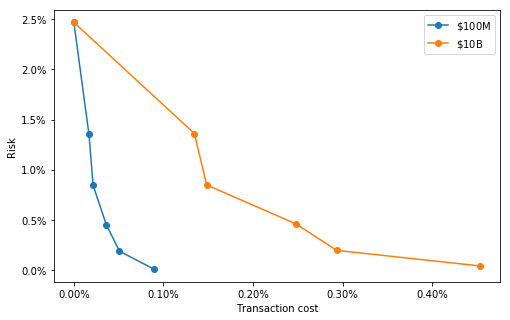

In [77]:
plt.figure(figsize=(8,5))
for v1 in table.index.levels[0][:]:
    x = table.loc[v1]['Trans. costs']
    y = table.loc[v1]['Active risk']
    plt.plot(np.array(x),np.array(y), 'o-', label='$%s\mathrm{%s}$'%(v1[:-1],v1[-1:]))
plt.legend(loc='upper right')
plt.xlabel('Transaction cost')
plt.ylabel('Risk')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
#plt.savefig(plotdir+'basic_frontier.png')